# **Importing library&function**






In [141]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, mean_squared_error, auc
from IPython.core.display import display, HTML
import numpy as np
import time
import os
from google.colab import drive
import itertools

!pip install split_folders
import splitfolders

!pip install scikit-learn

In [142]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [143]:
!ls /content/drive/MyDrive/ColabNotebooks/FinalProject/Dataset/grayscale/
import splitfolders
import os
loc = "/content/drive/MyDrive/ColabNotebooks/FinalProject/Dataset/grayscale/"
# csvloc = "/content/drive/MyDrive/ColabNotebooks/FinalProject/Result/"

gray_cataract  gray_diabetic_retinopathy  gray_glaucoma  gray_normal


In [144]:
import os
splitfolders.ratio(loc,output = "outputgrayscale",ratio = (0.80,0.10,0.10))
for dirpath,dirname,filename in os.walk("./outputgrayscale"):
  print(f"There are {len(dirname)} directories and {len(filename)} images in '{dirpath}'.")

Copying files: 4238 files [00:10, 387.82 files/s]

There are 3 directories and 0 images in './outputgrayscale'.
There are 4 directories and 0 images in './outputgrayscale/val'.
There are 0 directories and 156 images in './outputgrayscale/val/gray_cataract'.
There are 0 directories and 160 images in './outputgrayscale/val/gray_normal'.
There are 0 directories and 163 images in './outputgrayscale/val/gray_diabetic_retinopathy'.
There are 0 directories and 151 images in './outputgrayscale/val/gray_glaucoma'.
There are 4 directories and 0 images in './outputgrayscale/train'.
There are 0 directories and 943 images in './outputgrayscale/train/gray_cataract'.
There are 0 directories and 966 images in './outputgrayscale/train/gray_normal'.
There are 0 directories and 989 images in './outputgrayscale/train/gray_diabetic_retinopathy'.
There are 0 directories and 915 images in './outputgrayscale/train/gray_glaucoma'.
There are 4 directories and 0 images in './outputgrayscale/test'.
There are 0 directories and 106 images in './outputgrayscale/test

In [145]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 6,
                                             min_delta = 0.0001)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",factor = 0.2,
                                                patience = 4,min_lr = 1e-7)

In [146]:
data_aug = tf.keras.Sequential([
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomFlip("horizontal")
],name = "data_augmentation_layer")

In [147]:
def predict_labels(model, X_test):
    return model.predict(X_test)

def display_classification_report(y_test, y_pred):
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

def calculate_specificity(y_test, y_pred):
    # tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # specificity = tn / (tn + fp)
    # print(f"Specificity: {specificity}")
    cm = confusion_matrix(y_test, y_pred)
    specificity = []
    for i in range(cm.shape[0]):
      spec = cm[i, i] / (np.sum(cm[i, :]) - cm[i, i] + np.sum(cm[:, :]) - np.sum(cm[i, :]))
      specificity.append(spec)
    print(f"Specificity: {specificity}")

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize
    n_classes = cm.shape[0]  # find the number of classes

    specificity = []  # To store specificity values for each class

    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    ax.set(
        title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels
    )

    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    plt.xticks(rotation=70, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    threshold = (cm.max() + cm.min()) / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        specificity_val = (cm.sum() - cm[i].sum() - cm[:, j].sum() + cm[i, j]) / (
            cm.sum() - cm[:, j].sum()
        )
        specificity.append(specificity_val)

        if norm:
            plt.text(
                j,
                i,
                f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%,\n {specificity_val*100:.1f}%)",
                #  f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%, Specificity: {specificity_val*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size,
            )
        else:
            plt.text(
                j,
                i,
                f"{cm[i, j]} ( {specificity_val*100:.1f}%)",
                #  f"{cm[i, j]} (Specificity: {specificity_val*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size,
            )

    if savefig:
        fig.savefig("confusion_matrix.png")

    return specificity

def calculate_mse(y_test, y_probs, n_classes):
  y_true_onehot = tf.keras.utils.to_categorical(y_test, n_classes)
  mse = mean_squared_error(y_true_onehot, y_probs)
  print(f"Mean Squared Error: : {mse}")
  return y_true_onehot

def calculate_roc_auc_score(y_test, y_probs):
  auc_roc = roc_auc_score(y_test, y_probs, multi_class='ovr', average=None)
  average_auc_roc = np.mean(auc_roc)
  print(f"The average AUC-ROC is {average_auc_roc}")

In [148]:
def sharpen_image(image, factor=1.5):
    adjusted = tf.image.adjust_contrast(image, factor)
    return adjusted

# **Batch size: 16**

In [149]:
epoch = 20
batchsize = 16

In [150]:
train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_classes = sorted([name for name in os.listdir(train_dir)])
class_names = train_classes  # Assuming class names are the same across train, test, and val

# Load datasets
train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 3813 files belonging to 4 classes.
Found 428 files belonging to 4 classes.
Found 630 files belonging to 4 classes.


In [151]:
class_names = train_data.class_names  # Store class names before transformations

# Apply transformations using map() function
train_data = train_data.map(lambda x, y: (sharpen_image(x), y))
test_data = test_data.map(lambda x, y: (sharpen_image(x), y))
val_data = val_data.map(lambda x, y: (sharpen_image(x), y))


# **EfficientNetV2B3 Model**

In [152]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


In [153]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = data_aug(inputs)
# x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 1)     0         
 equential)                                                      
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d_1  (None, 1536)              0         
 3 (GlobalAveragePooling2D)                                      
                                                                 
 dense_38 (Dense)            (None, 32)                49184     
                                                          

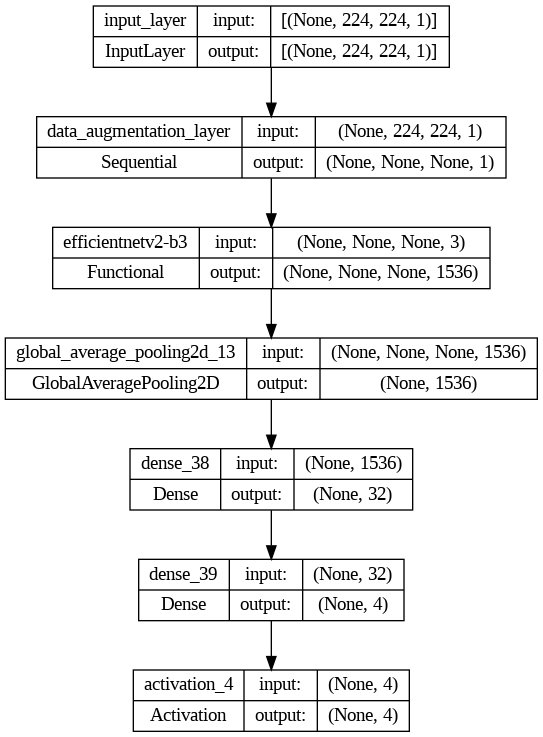

In [154]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [155]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [156]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
239/239 [==============================] - 30s 76ms/step - loss: 0.7099 - accuracy: 0.7102 - val_loss: 0.7424 - val_accuracy: 0.6857 - lr: 0.0010
Epoch 2/20
239/239 [==============================] - 14s 60ms/step - loss: 0.5827 - accuracy: 0.7666 - val_loss: 0.8133 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 3/20
239/239 [==============================] - 14s 60ms/step - loss: 0.5230 - accuracy: 0.7949 - val_loss: 0.6343 - val_accuracy: 0.7444 - lr: 0.0010
Epoch 4/20
239/239 [==============================] - 15s 61ms/step - loss: 0.5041 - accuracy: 0.8067 - val_loss: 0.6367 - val_accuracy: 0.7556 - lr: 0.0010
Epoch 5/20
239/239 [==============================] - 14s 59ms/step - loss: 0.4925 - accuracy: 0.8046 - val_loss: 0.5916 - val_accuracy: 0.7730 - lr: 0.0010
Epoch 6/20
239/239 [==============================] - 14s 60ms/step - loss: 0.4632 - accuracy: 0.8230 - val_loss: 0.5822 - val_accuracy: 0.7508 - lr: 0.0010
Epoch 7/20
239/239 [==============================] - 14s 

EfficientNetV2B3 Evaluation

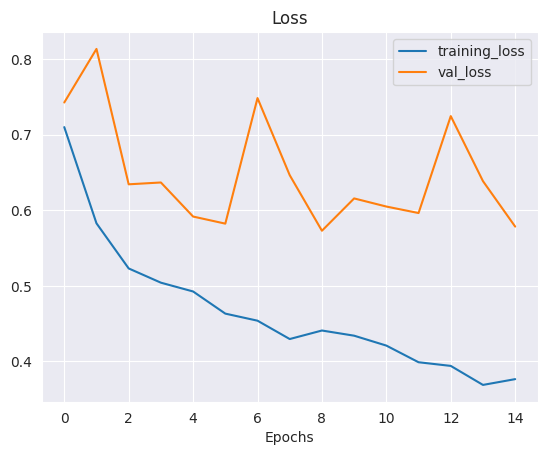

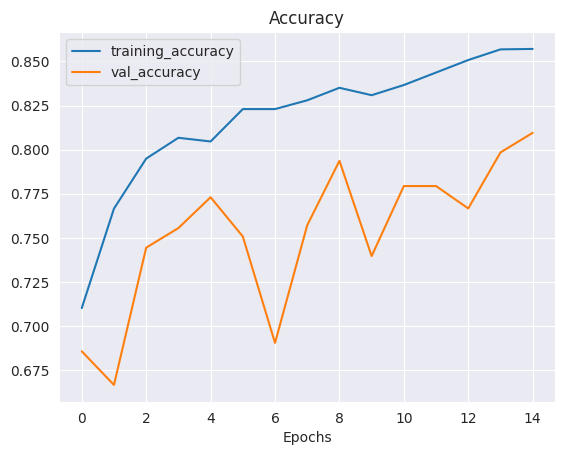

In [157]:
plot_loss_curves(efficient_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 1s 42ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       106
           1       0.90      0.94      0.92       111
           2       0.94      0.50      0.65       103
           3       0.69      0.95      0.80       108

    accuracy                           0.82       428
   macro avg       0.85      0.82      0.81       428
weighted avg       0.85      0.82      0.81       428

Specificity: [0.281437125748503, 0.32098765432098764, 0.13527851458885942, 0.3169230769230769]
Mean Squared Error: : 0.1256406456232071
The average AUC-ROC is 0.9639706418257867


[0.9625,
 0.6602564102564102,
 0.7245989304812834,
 0.6510791366906474,
 0.653125,
 0.9775641025641025,
 0.7032085561497327,
 0.6258992805755396,
 0.71875,
 0.6955128205128205,
 0.8609625668449198,
 0.7410071942446043,
 0.665625,
 0.6666666666666666,
 0.7112299465240641,
 0.9820143884892086]

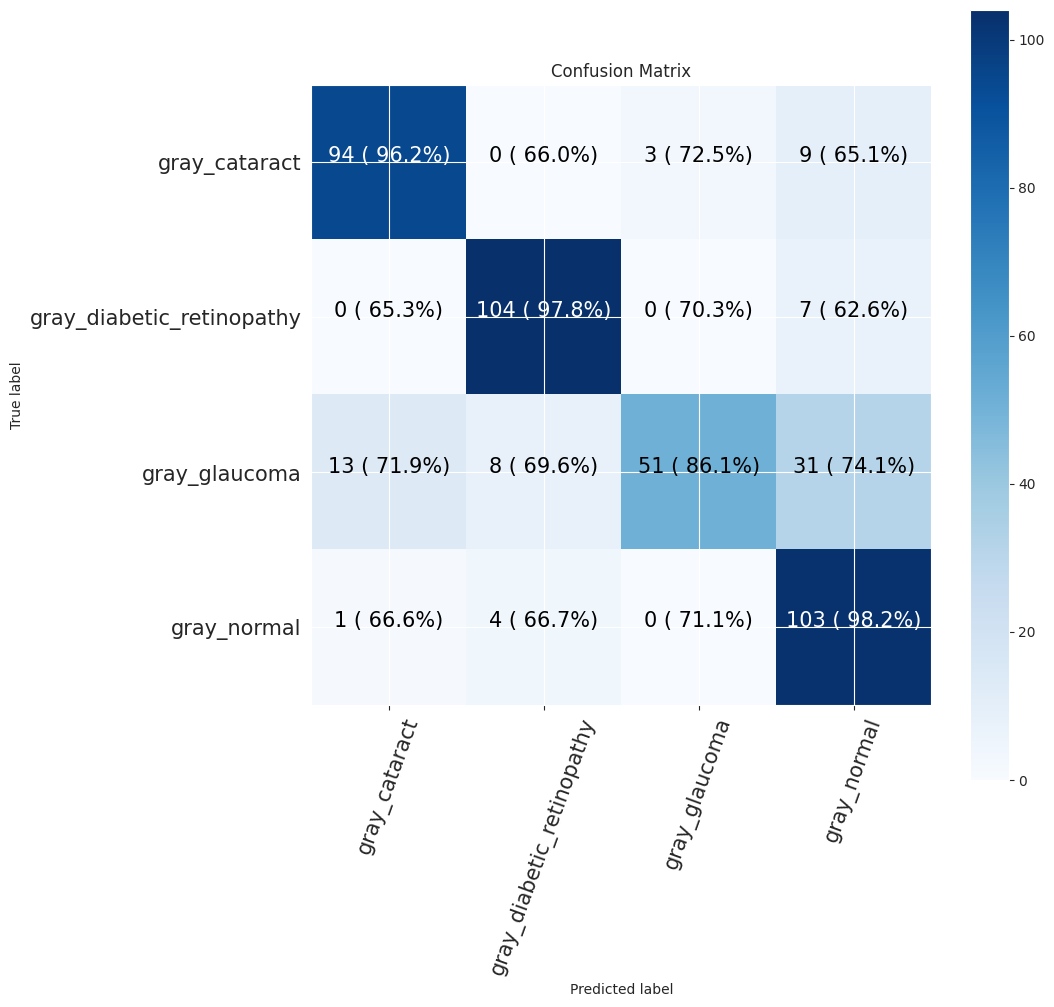

In [158]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]

pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels, pred_classes, classes=class_names, figsize=(10, 10))

# make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


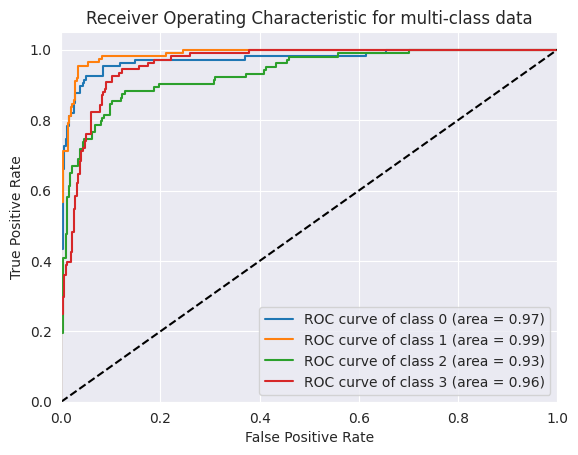

In [159]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [160]:

from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 26, 26, 128)      

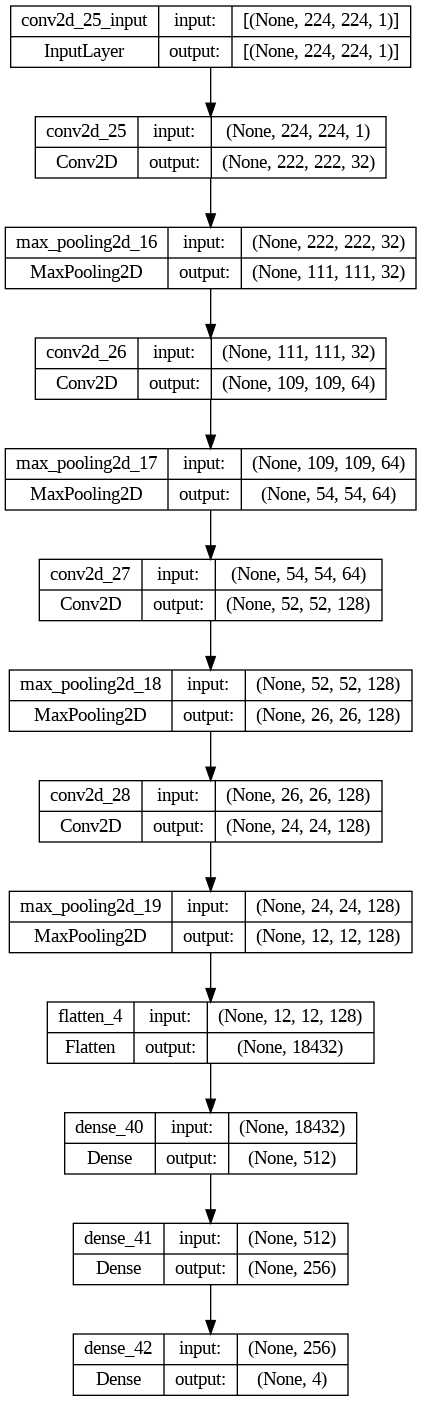

In [161]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [162]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [163]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
239/239 [==============================] - 10s 24ms/step - loss: 2.5510 - accuracy: 0.4957 - val_loss: 0.9034 - val_accuracy: 0.5254 - lr: 0.0010
Epoch 2/20
239/239 [==============================] - 5s 22ms/step - loss: 0.8014 - accuracy: 0.6252 - val_loss: 0.7334 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 3/20
239/239 [==============================] - 5s 22ms/step - loss: 0.7777 - accuracy: 0.6370 - val_loss: 0.7430 - val_accuracy: 0.6746 - lr: 0.0010
Epoch 4/20
239/239 [==============================] - 5s 22ms/step - loss: 0.7226 - accuracy: 0.6572 - val_loss: 0.6519 - val_accuracy: 0.7175 - lr: 0.0010
Epoch 5/20
239/239 [==============================] - 5s 22ms/step - loss: 0.6335 - accuracy: 0.7120 - val_loss: 0.6329 - val_accuracy: 0.7190 - lr: 0.0010
Epoch 6/20
239/239 [==============================] - 5s 21ms/step - loss: 0.6047 - accuracy: 0.7215 - val_loss: 0.7197 - val_accuracy: 0.6698 - lr: 0.0010
Epoch 7/20
239/239 [==============================] - 5s 21ms/s

CNN Evaluation

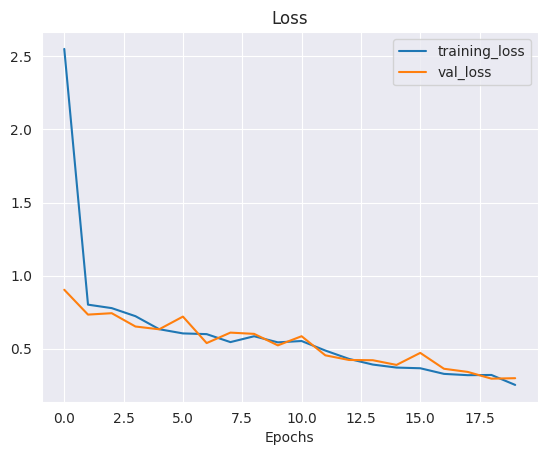

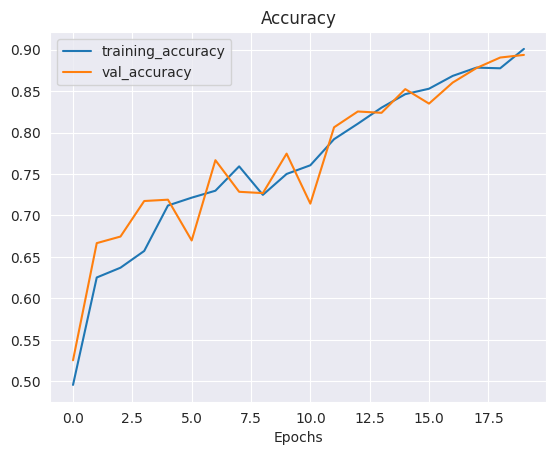

In [164]:
plot_loss_curves(cnn_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 0s 8ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       106
           1       1.00      0.99      1.00       111
           2       0.78      0.67      0.72       103
           3       0.81      0.86      0.83       108

    accuracy                           0.84       428
   macro avg       0.84      0.84      0.84       428
weighted avg       0.84      0.84      0.84       428

Specificity: [0.26253687315634217, 0.34591194968553457, 0.19220055710306408, 0.27761194029850744]
Mean Squared Error: : 0.11946272104978561
The average AUC-ROC is 0.9586541854074202


[0.945859872611465,
 0.6666666666666666,
 0.7197640117994101,
 0.6805111821086262,
 0.6464968152866242,
 0.9968553459119497,
 0.672566371681416,
 0.6485623003194888,
 0.732484076433121,
 0.6761006289308176,
 0.8997050147492626,
 0.7188498402555911,
 0.6751592356687898,
 0.660377358490566,
 0.7079646017699115,
 0.952076677316294]

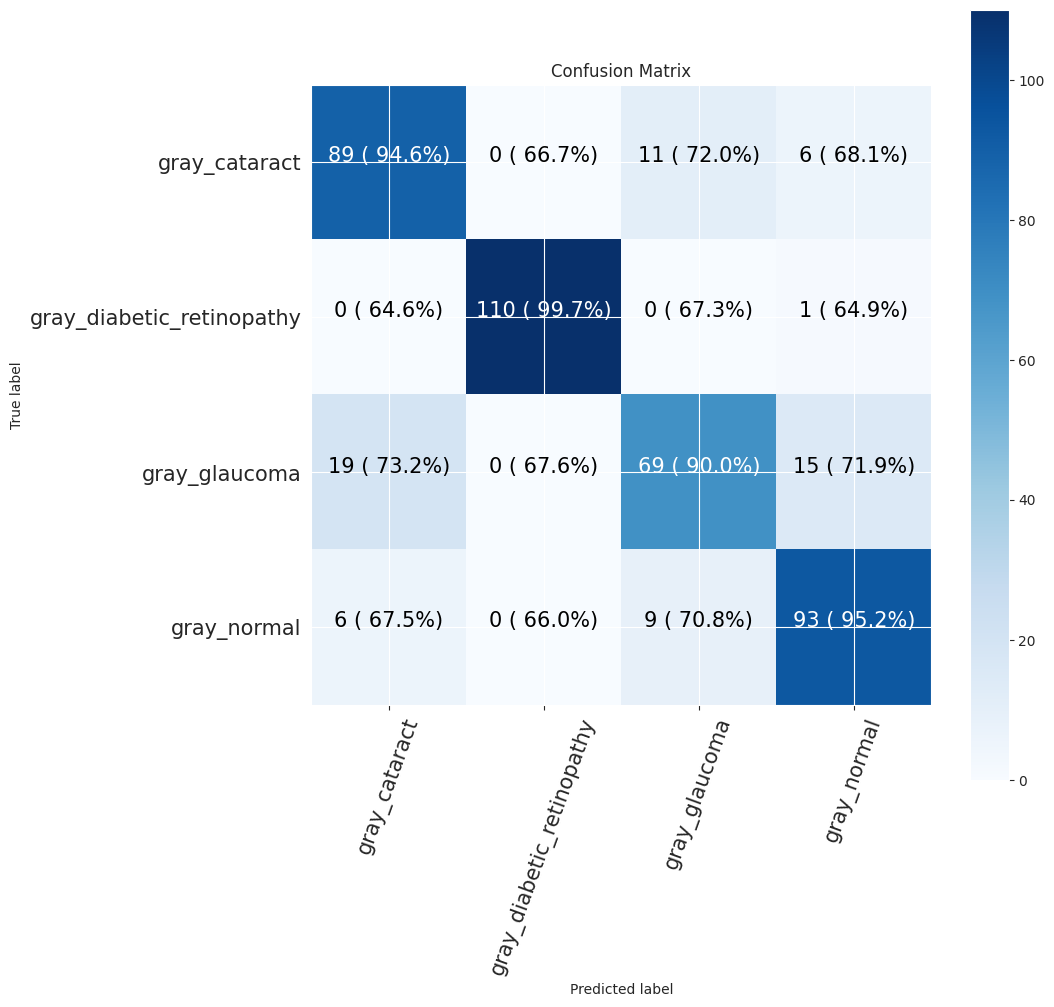

In [165]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


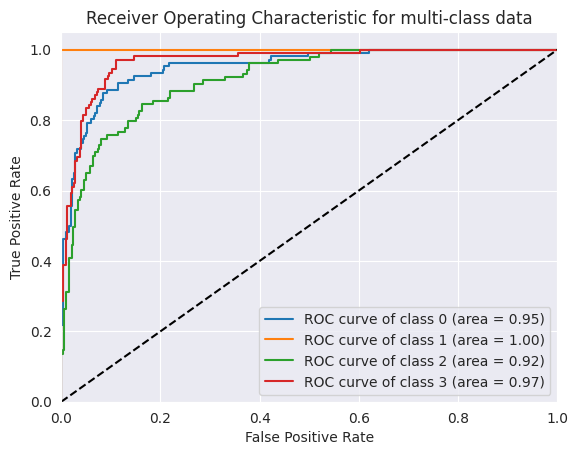

In [166]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [167]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_29 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
 4 (GlobalAveragePooling2D)                                      
                                                                 
 dense_43 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_44 (Dense)            (None, 4)                 4100      
                                                          

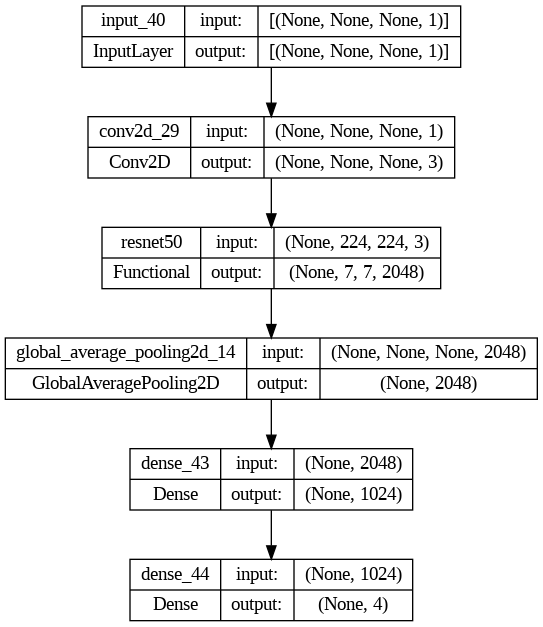

In [168]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [169]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [170]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
239/239 [==============================] - 39s 147ms/step - loss: 0.6699 - accuracy: 0.7645 - val_loss: 0.4037 - val_accuracy: 0.8302 - lr: 0.0010
Epoch 2/20
239/239 [==============================] - 33s 138ms/step - loss: 0.3593 - accuracy: 0.8610 - val_loss: 0.2760 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 3/20
239/239 [==============================] - 33s 138ms/step - loss: 0.3122 - accuracy: 0.8815 - val_loss: 0.4049 - val_accuracy: 0.8349 - lr: 0.0010
Epoch 4/20
239/239 [==============================] - 33s 138ms/step - loss: 0.2575 - accuracy: 0.8948 - val_loss: 0.4254 - val_accuracy: 0.8302 - lr: 0.0010
Epoch 5/20
239/239 [==============================] - 33s 138ms/step - loss: 0.2611 - accuracy: 0.8996 - val_loss: 0.2164 - val_accuracy: 0.9302 - lr: 0.0010
Epoch 6/20
239/239 [==============================] - 33s 138ms/step - loss: 0.2450 - accuracy: 0.9064 - val_loss: 0.2258 - val_accuracy: 0.9190 - lr: 0.0010
Epoch 7/20
239/239 [==============================] 

ResNet50 Evaluation

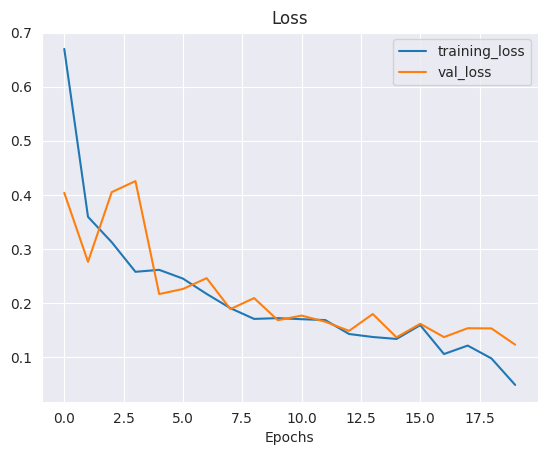

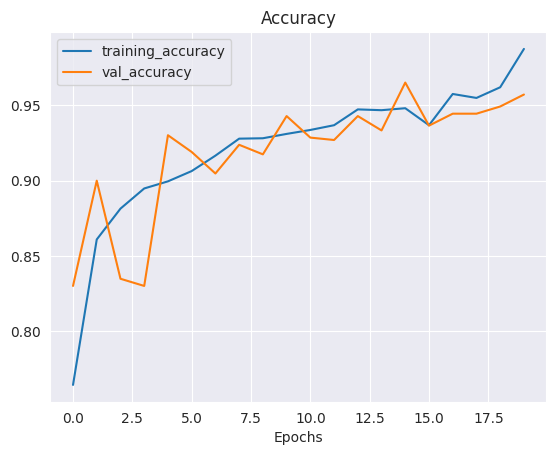

In [171]:
plot_loss_curves(resnet50_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 1s 48ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       106
           1       0.99      1.00      1.00       111
           2       0.86      0.81      0.83       103
           3       0.84      0.90      0.87       108

    accuracy                           0.90       428
   macro avg       0.90      0.90      0.90       428
weighted avg       0.90      0.90      0.90       428

Specificity: [0.2891566265060241, 0.3501577287066246, 0.24057971014492754, 0.2930513595166163]
Mean Squared Error: : 0.10632972419261932
The average AUC-ROC is 0.9879907515582793


[0.9692307692307692,
 0.6645569620253164,
 0.6978851963746223,
 0.6730769230769231,
 0.6584615384615384,
 1.0,
 0.6646525679758308,
 0.6442307692307693,
 0.6953846153846154,
 0.6772151898734177,
 0.9395770392749244,
 0.717948717948718,
 0.676923076923077,
 0.6582278481012658,
 0.6978851963746223,
 0.9647435897435898]

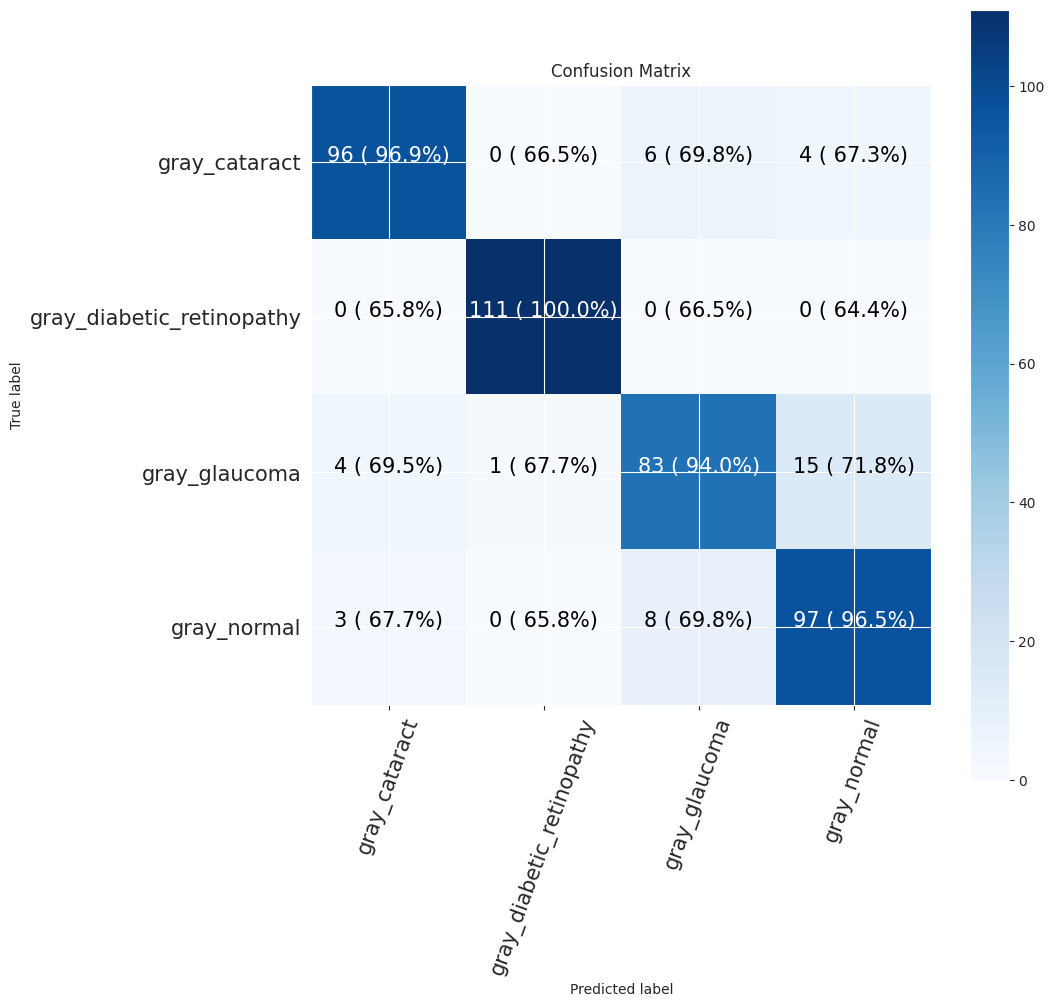

In [172]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


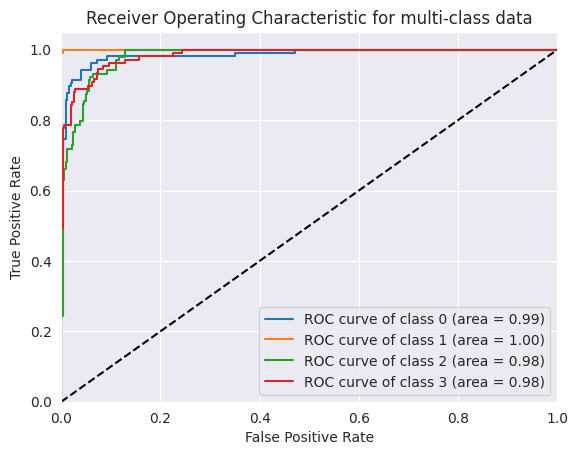

In [173]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [174]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_43 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_30 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
 5 (GlobalAveragePooling2D)                                      
                                                                 
 dense_45 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_46 (Dense)            (None, 4)                 4100      
                                                          

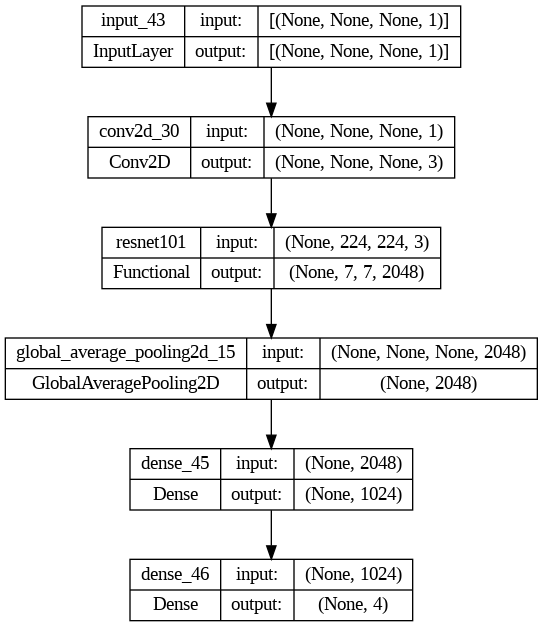

In [175]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [176]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [177]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
239/239 [==============================] - 64s 236ms/step - loss: 0.6623 - accuracy: 0.7705 - val_loss: 0.3618 - val_accuracy: 0.8635 - lr: 0.0010
Epoch 2/20
239/239 [==============================] - 54s 226ms/step - loss: 0.3832 - accuracy: 0.8440 - val_loss: 0.3510 - val_accuracy: 0.8683 - lr: 0.0010
Epoch 3/20
239/239 [==============================] - 54s 226ms/step - loss: 0.3270 - accuracy: 0.8707 - val_loss: 0.3434 - val_accuracy: 0.8683 - lr: 0.0010
Epoch 4/20
239/239 [==============================] - 54s 226ms/step - loss: 0.2688 - accuracy: 0.8930 - val_loss: 0.3608 - val_accuracy: 0.8571 - lr: 0.0010
Epoch 5/20
239/239 [==============================] - 54s 226ms/step - loss: 0.2618 - accuracy: 0.8925 - val_loss: 0.2893 - val_accuracy: 0.8984 - lr: 0.0010
Epoch 6/20
239/239 [==============================] - 54s 226ms/step - loss: 0.2182 - accuracy: 0.9150 - val_loss: 0.2184 - val_accuracy: 0.9159 - lr: 0.0010
Epoch 7/20
239/239 [==============================] 

ResNet101 Evaluation

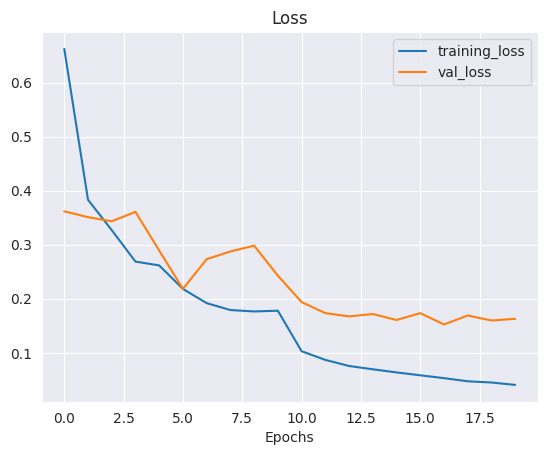

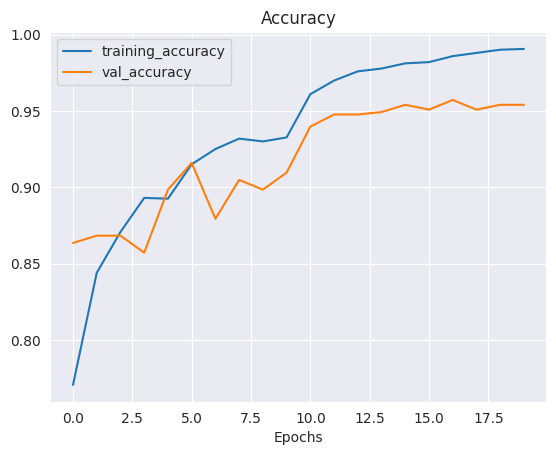

In [178]:
plot_loss_curves(resnet101_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 2s 82ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.82      0.87       106
           1       0.97      0.97      0.97       111
           2       0.81      0.84      0.82       103
           3       0.84      0.91      0.88       108

    accuracy                           0.89       428
   macro avg       0.89      0.89      0.89       428
weighted avg       0.89      0.89      0.89       428

Specificity: [0.25513196480938416, 0.3375, 0.25513196480938416, 0.296969696969697]
Mean Squared Error: : 0.10870155692100525
The average AUC-ROC is 0.9810753977437247


[0.9432835820895522,
 0.6656151419558359,
 0.709375,
 0.6794871794871795,
 0.6686567164179105,
 0.9905362776025236,
 0.65625,
 0.6506410256410257,
 0.7044776119402985,
 0.6813880126182965,
 0.95,
 0.7019230769230769,
 0.6835820895522388,
 0.6624605678233438,
 0.684375,
 0.967948717948718]

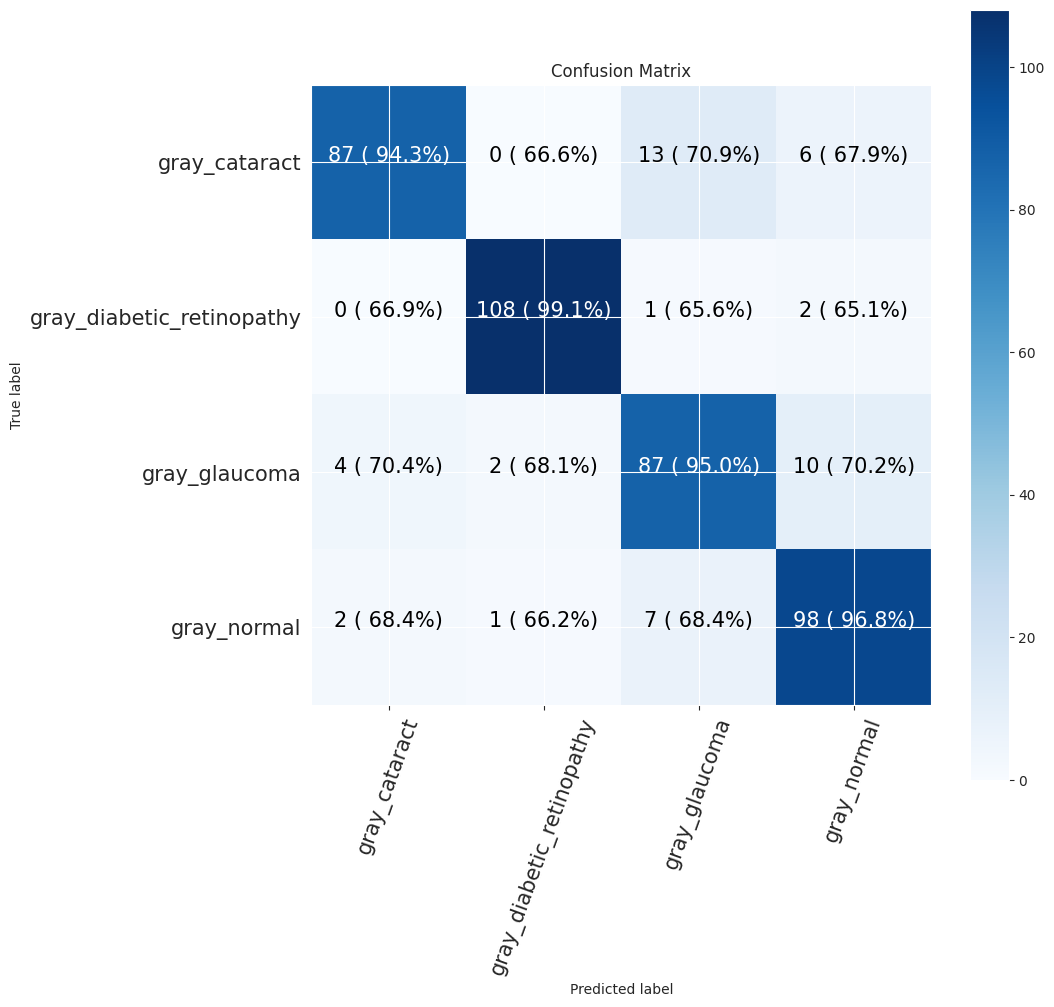

In [179]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


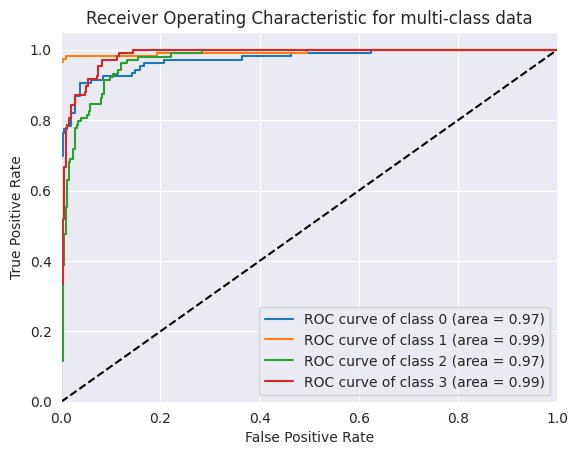

In [180]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **Batch size: 32**

In [181]:
epoch = 20
batchsize = 32

In [182]:
train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_classes = sorted([name for name in os.listdir(train_dir)])
class_names = train_classes  # Assuming class names are the same across train, test, and val

# Load datasets
train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 3813 files belonging to 4 classes.
Found 428 files belonging to 4 classes.
Found 630 files belonging to 4 classes.


In [183]:
train_data = train_data.map(lambda x, y: (sharpen_image(x), y))
test_data = test_data.map(lambda x, y: (sharpen_image(x), y))
val_data = val_data.map(lambda x, y: (sharpen_image(x), y))

# **EfficientNetV2B3 Model**

In [184]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


In [185]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = data_aug(inputs)
# x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 1)     0         
 equential)                                                      
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d_1  (None, 1536)              0         
 6 (GlobalAveragePooling2D)                                      
                                                                 
 dense_47 (Dense)            (None, 32)                49184     
                                                          

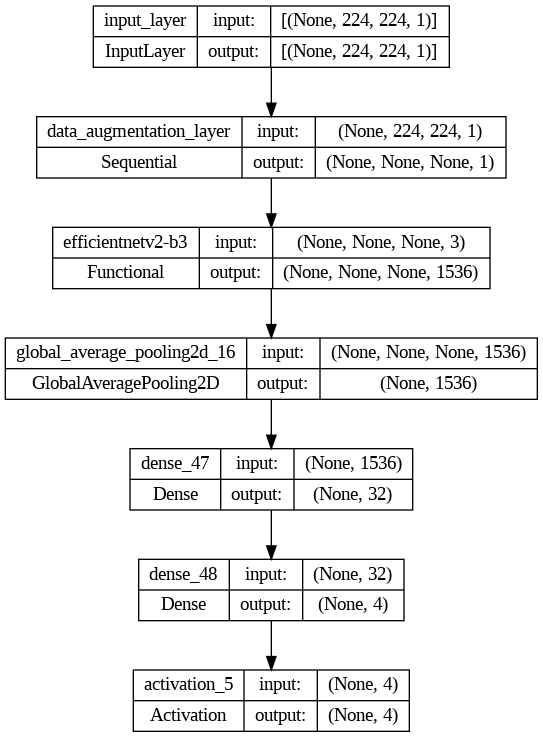

In [186]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [187]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [188]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
120/120 [==============================] - 61s 408ms/step - loss: 0.7023 - accuracy: 0.7126 - val_loss: 0.8129 - val_accuracy: 0.6762 - lr: 0.0010
Epoch 2/20
120/120 [==============================] - 41s 341ms/step - loss: 0.5683 - accuracy: 0.7734 - val_loss: 0.9999 - val_accuracy: 0.5905 - lr: 0.0010
Epoch 3/20
120/120 [==============================] - 45s 375ms/step - loss: 0.5372 - accuracy: 0.7920 - val_loss: 0.8631 - val_accuracy: 0.6492 - lr: 0.0010
Epoch 4/20
120/120 [==============================] - 41s 339ms/step - loss: 0.5034 - accuracy: 0.8002 - val_loss: 0.6616 - val_accuracy: 0.7397 - lr: 0.0010
Epoch 5/20
120/120 [==============================] - 37s 311ms/step - loss: 0.4799 - accuracy: 0.8065 - val_loss: 0.5986 - val_accuracy: 0.7603 - lr: 0.0010
Epoch 6/20
120/120 [==============================] - 33s 280ms/step - loss: 0.4643 - accuracy: 0.8183 - val_loss: 0.9308 - val_accuracy: 0.6556 - lr: 0.0010
Epoch 7/20
120/120 [==============================] 

EfficientNetV2B3 Evaluation

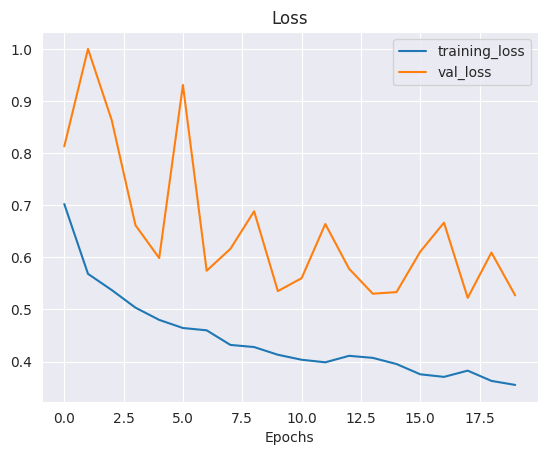

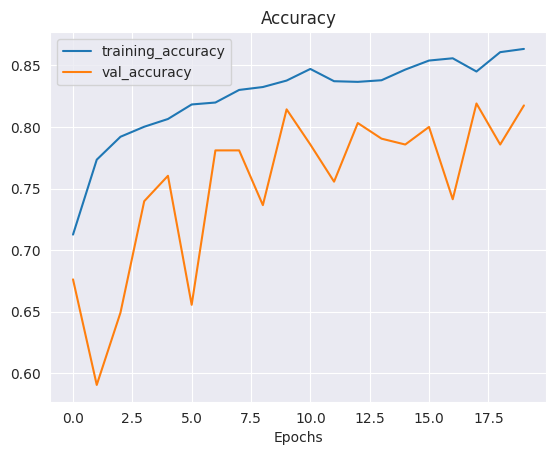

In [189]:
plot_loss_curves(efficient_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 1s 77ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       106
           1       0.90      0.96      0.93       111
           2       0.96      0.50      0.66       103
           3       0.66      0.94      0.78       108

    accuracy                           0.82       428
   macro avg       0.86      0.82      0.81       428
weighted avg       0.86      0.82      0.81       428

Specificity: [0.27002967359050445, 0.3333333333333333, 0.13829787234042554, 0.3128834355828221]
Mean Squared Error: : 0.12401261925697327
The average AUC-ROC is 0.967076670409148


[0.9541284403669725,
 0.656957928802589,
 0.7219251336898396,
 0.6605839416058394,
 0.6605504587155964,
 0.9870550161812298,
 0.7032085561497327,
 0.6094890510948905,
 0.7125382262996942,
 0.6893203883495146,
 0.8636363636363636,
 0.7518248175182481,
 0.672782874617737,
 0.6666666666666666,
 0.7112299465240641,
 0.9781021897810219]

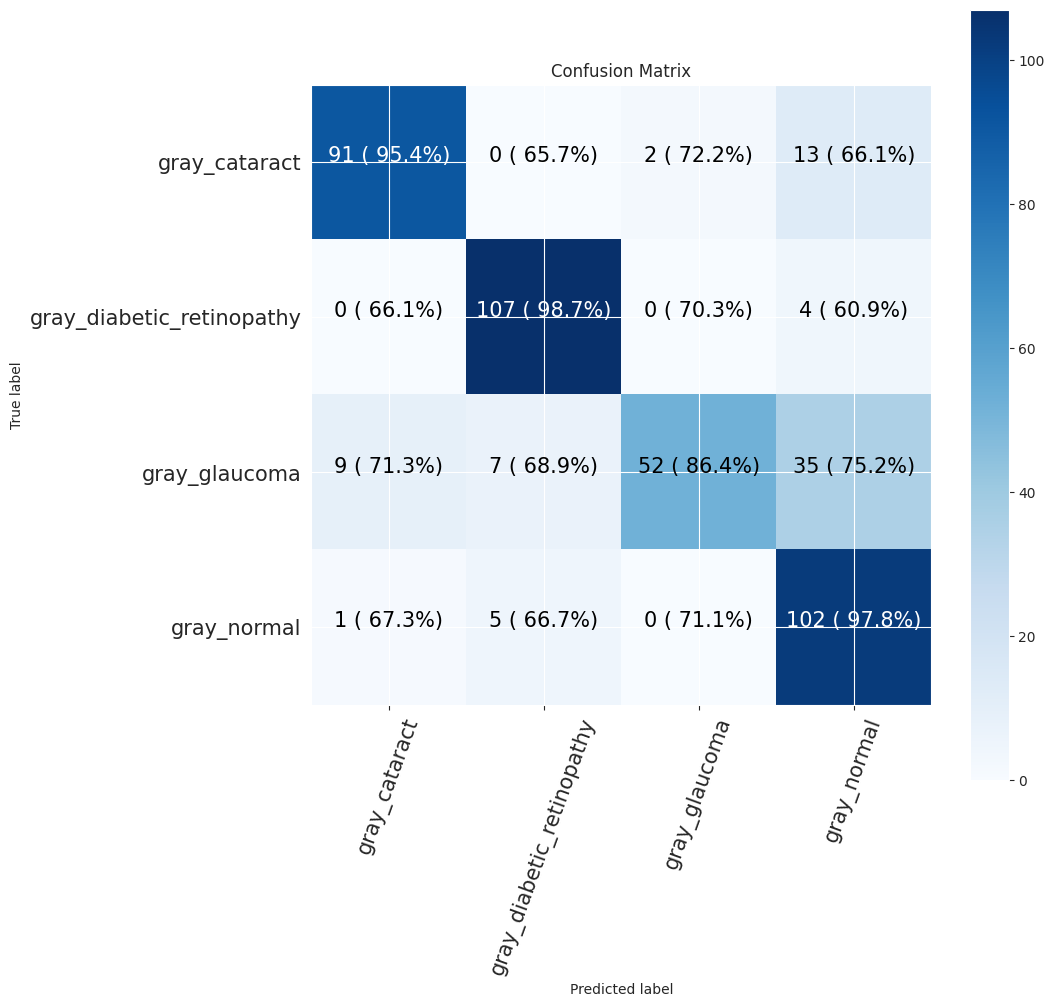

In [190]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


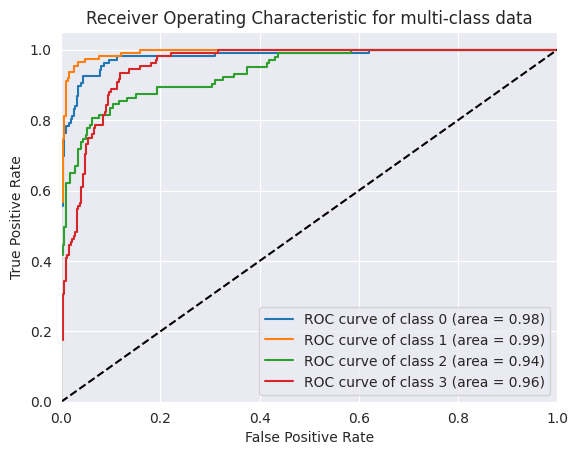

In [191]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [192]:
from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_33 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 26, 26, 128)      

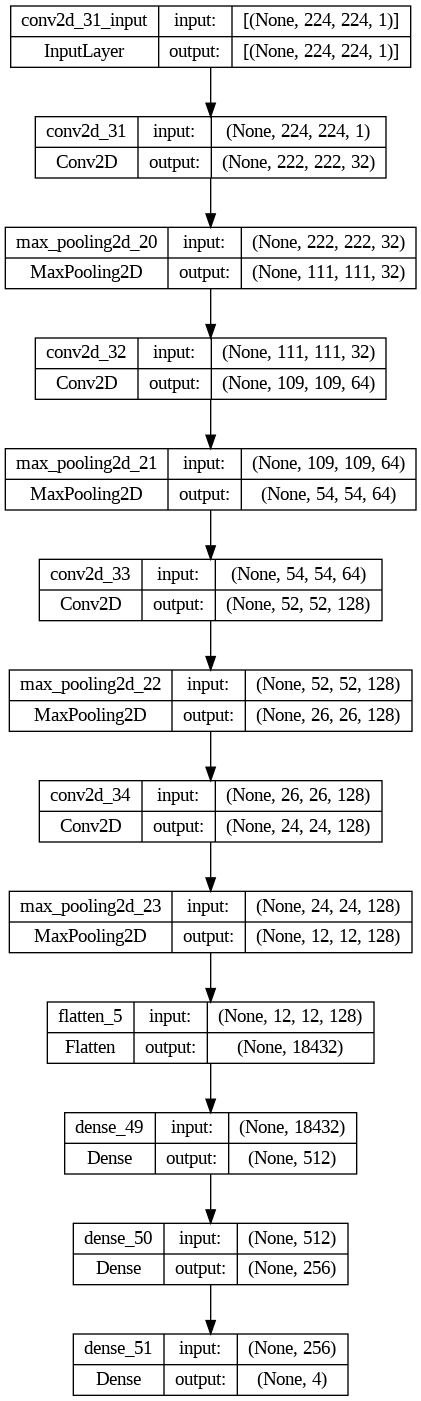

In [193]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [194]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [195]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
120/120 [==============================] - 7s 41ms/step - loss: 3.5372 - accuracy: 0.4763 - val_loss: 0.9817 - val_accuracy: 0.5190 - lr: 0.0010
Epoch 2/20
120/120 [==============================] - 4s 35ms/step - loss: 0.8540 - accuracy: 0.5799 - val_loss: 0.7832 - val_accuracy: 0.6127 - lr: 0.0010
Epoch 3/20
120/120 [==============================] - 4s 35ms/step - loss: 0.7679 - accuracy: 0.6140 - val_loss: 0.7776 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 4/20
120/120 [==============================] - 4s 35ms/step - loss: 0.7450 - accuracy: 0.6491 - val_loss: 0.7692 - val_accuracy: 0.6698 - lr: 0.0010
Epoch 5/20
120/120 [==============================] - 4s 36ms/step - loss: 0.6859 - accuracy: 0.6766 - val_loss: 0.6866 - val_accuracy: 0.6810 - lr: 0.0010
Epoch 6/20
120/120 [==============================] - 4s 36ms/step - loss: 0.6263 - accuracy: 0.7139 - val_loss: 0.5893 - val_accuracy: 0.7349 - lr: 0.0010
Epoch 7/20
120/120 [==============================] - 4s 36ms/st

CNN Evaluation

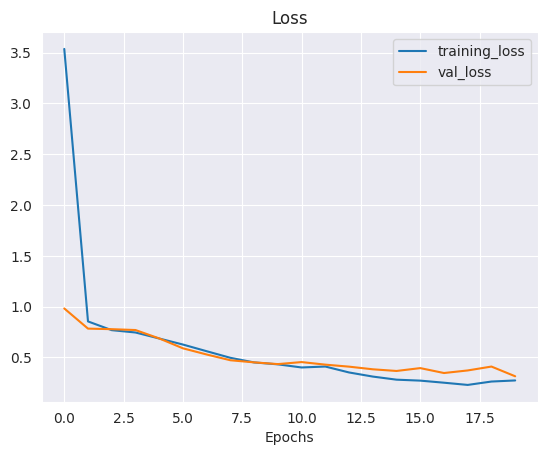

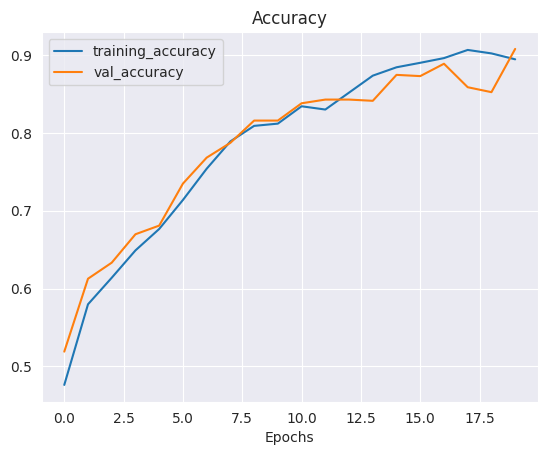

In [196]:
plot_loss_curves(cnn_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 12ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       106
           1       0.96      0.98      0.97       111
           2       0.67      0.77      0.71       103
           3       0.87      0.73      0.79       108

    accuracy                           0.83       428
   macro avg       0.83      0.83      0.83       428
weighted avg       0.83      0.83      0.83       428

Specificity: [0.25513196480938416, 0.34169278996865204, 0.22636103151862463, 0.22636103151862463]
Mean Squared Error: : 0.12238578498363495
The average AUC-ROC is 0.944175582668531


[0.9409937888198758,
 0.6634920634920635,
 0.7096774193548387,
 0.6943620178041543,
 0.65527950310559,
 0.9936507936507937,
 0.6483870967741936,
 0.6706231454005934,
 0.7142857142857143,
 0.6857142857142857,
 0.9225806451612903,
 0.7210682492581603,
 0.6894409937888198,
 0.6571428571428571,
 0.7193548387096774,
 0.913946587537092]

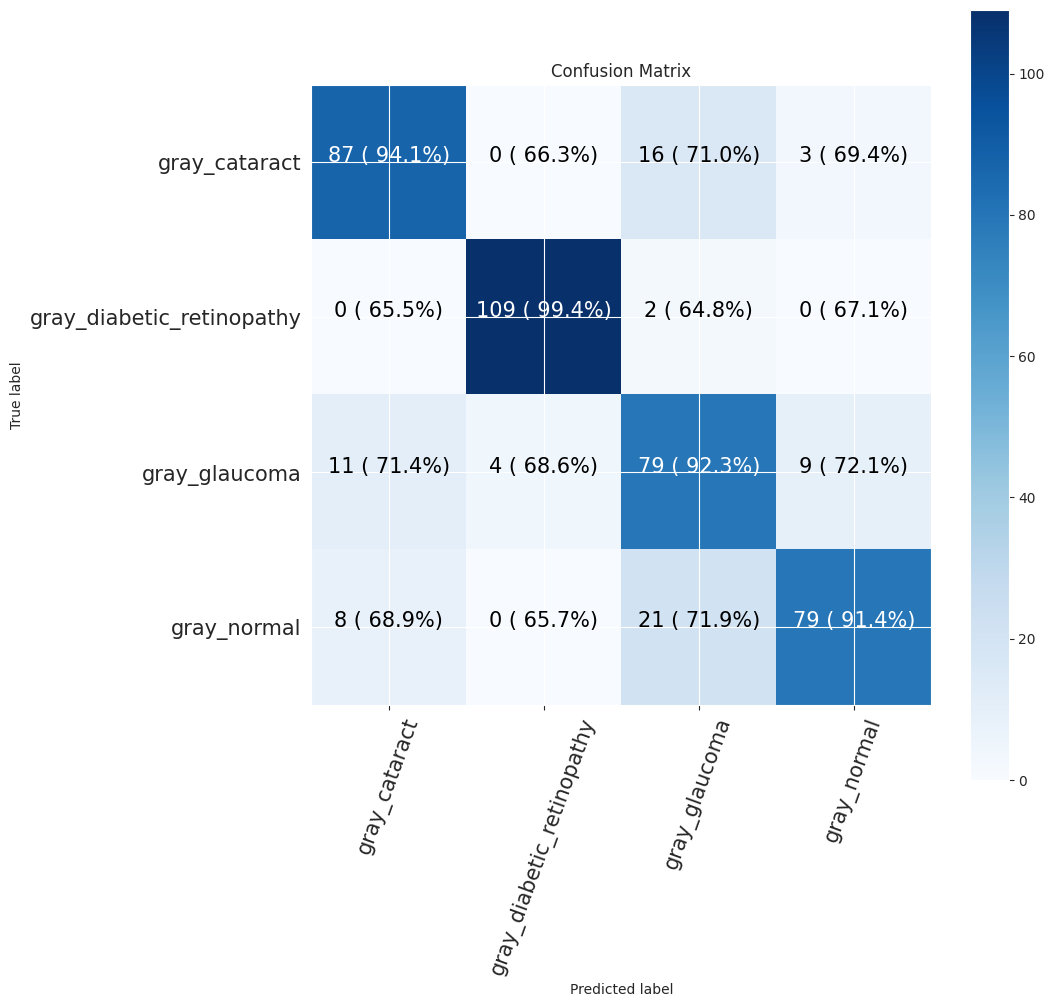

In [197]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


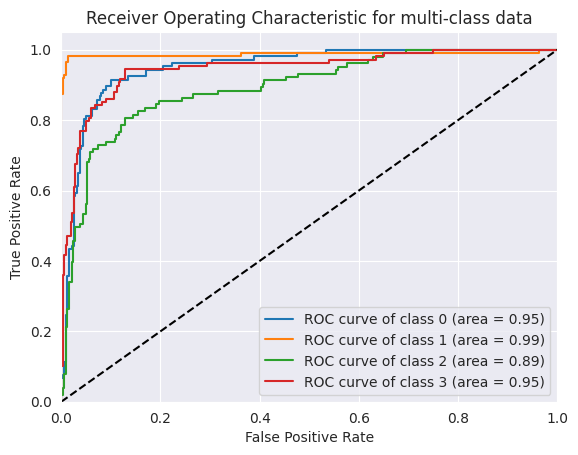

In [198]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [199]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_48 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_35 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
 7 (GlobalAveragePooling2D)                                      
                                                                 
 dense_52 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_53 (Dense)            (None, 4)                 4100      
                                                          

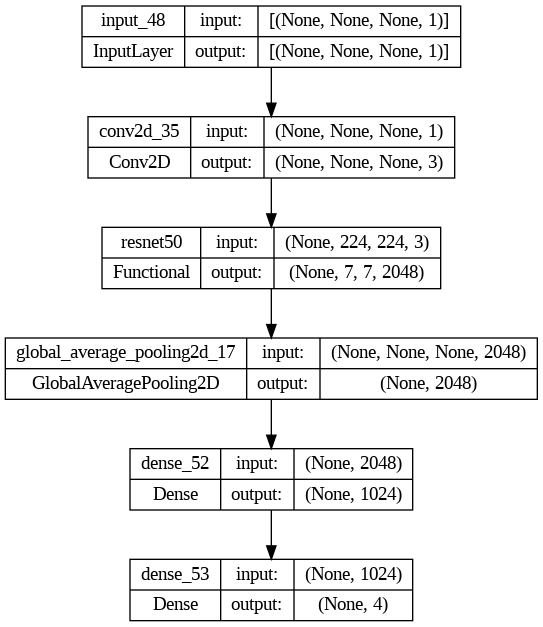

In [200]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [201]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [202]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
120/120 [==============================] - 39s 289ms/step - loss: 0.7168 - accuracy: 0.7561 - val_loss: 0.3736 - val_accuracy: 0.8635 - lr: 0.0010
Epoch 2/20
120/120 [==============================] - 32s 263ms/step - loss: 0.3505 - accuracy: 0.8670 - val_loss: 0.2941 - val_accuracy: 0.8794 - lr: 0.0010
Epoch 3/20
120/120 [==============================] - 31s 261ms/step - loss: 0.3034 - accuracy: 0.8788 - val_loss: 0.2998 - val_accuracy: 0.8794 - lr: 0.0010
Epoch 4/20
120/120 [==============================] - 32s 263ms/step - loss: 0.2793 - accuracy: 0.8867 - val_loss: 0.3287 - val_accuracy: 0.8762 - lr: 0.0010
Epoch 5/20
120/120 [==============================] - 32s 262ms/step - loss: 0.2179 - accuracy: 0.9156 - val_loss: 0.2239 - val_accuracy: 0.9143 - lr: 0.0010
Epoch 6/20
120/120 [==============================] - 31s 262ms/step - loss: 0.1914 - accuracy: 0.9268 - val_loss: 0.1864 - val_accuracy: 0.9222 - lr: 0.0010
Epoch 7/20
120/120 [==============================] 

ResNet50 Evaluation

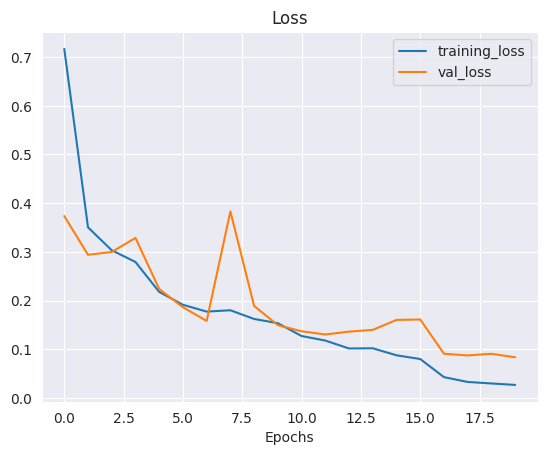

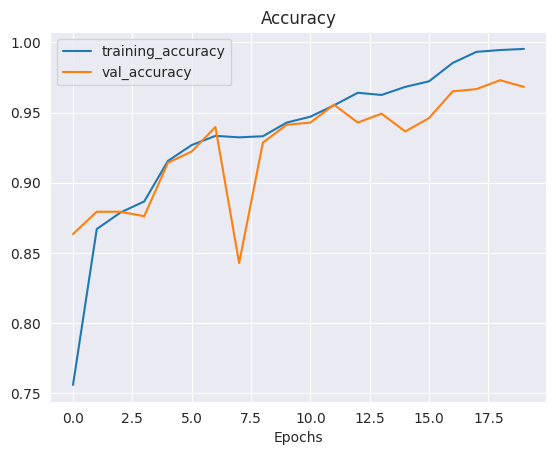

In [203]:
plot_loss_curves(resnet50_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 1s 91ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       106
           1       0.99      1.00      1.00       111
           2       0.84      0.87      0.86       103
           3       0.89      0.86      0.88       108

    accuracy                           0.91       428
   macro avg       0.91      0.91      0.91       428
weighted avg       0.91      0.91      0.91       428

Specificity: [0.2891566265060241, 0.3501577287066246, 0.26627218934911245, 0.27761194029850744]
Mean Squared Error: : 0.10482899844646454
The average AUC-ROC is 0.9900226763009659


[0.9690402476780186,
 0.6645569620253164,
 0.6853582554517134,
 0.6882716049382716,
 0.6563467492260062,
 1.0,
 0.6542056074766355,
 0.6574074074074074,
 0.6996904024767802,
 0.6772151898734177,
 0.9595015576323987,
 0.7006172839506173,
 0.6749226006191951,
 0.6582278481012658,
 0.7009345794392523,
 0.9537037037037037]

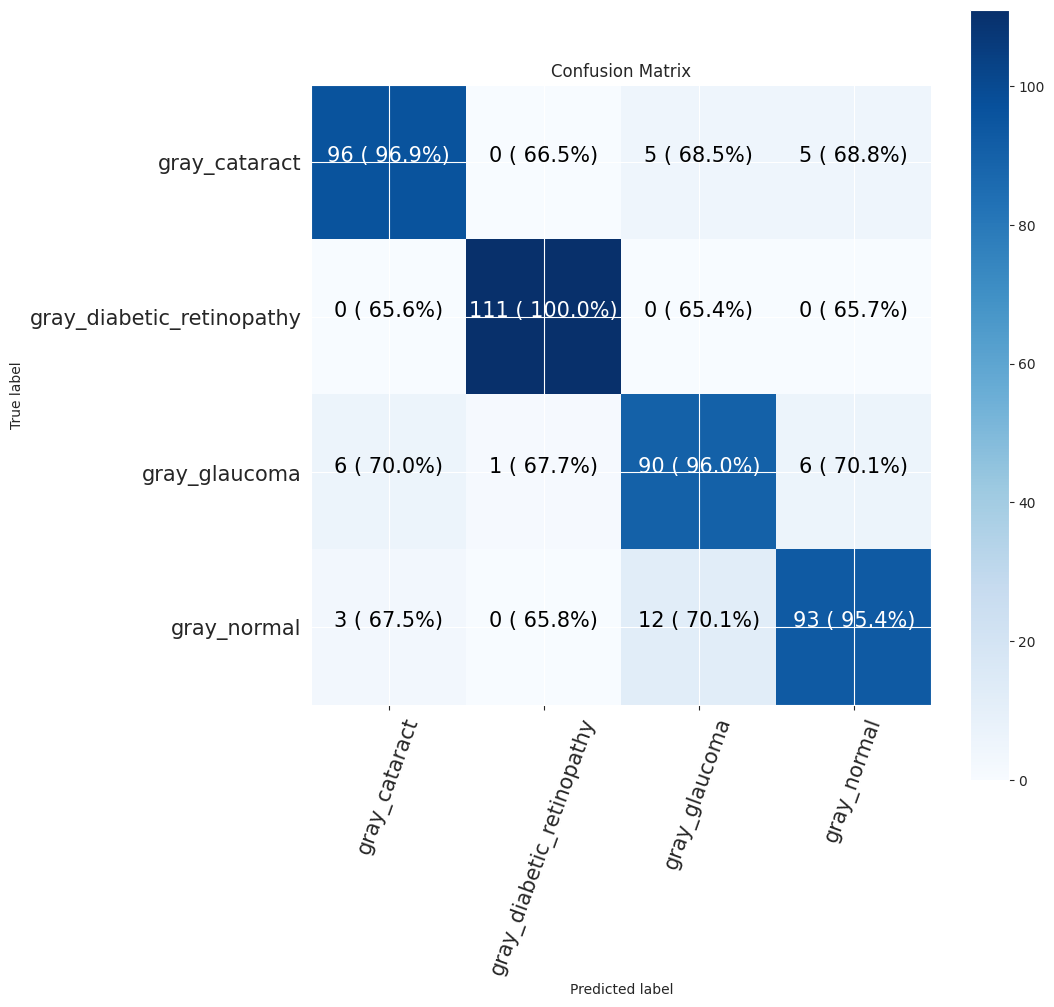

In [204]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


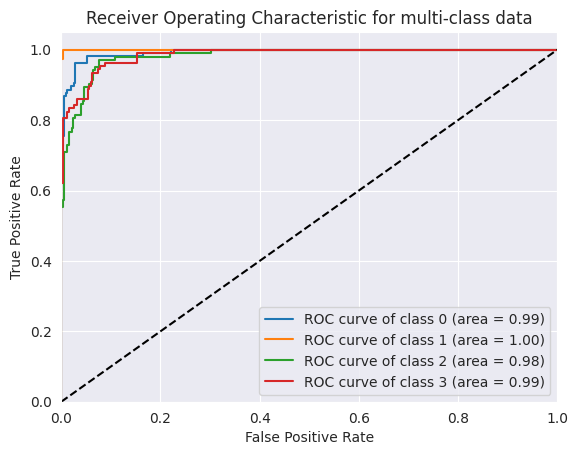

In [205]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [206]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_51 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_36 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
 8 (GlobalAveragePooling2D)                                      
                                                                 
 dense_54 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_55 (Dense)            (None, 4)                 4100      
                                                          

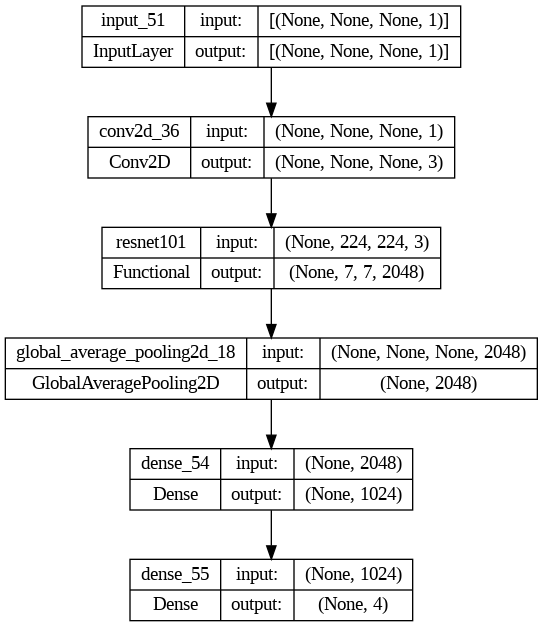

In [207]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [208]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [209]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
120/120 [==============================] - 62s 455ms/step - loss: 0.6676 - accuracy: 0.7661 - val_loss: 0.4512 - val_accuracy: 0.8206 - lr: 0.0010
Epoch 2/20
120/120 [==============================] - 52s 432ms/step - loss: 0.3885 - accuracy: 0.8510 - val_loss: 0.3721 - val_accuracy: 0.8667 - lr: 0.0010
Epoch 3/20
120/120 [==============================] - 52s 434ms/step - loss: 0.3043 - accuracy: 0.8862 - val_loss: 0.2652 - val_accuracy: 0.8857 - lr: 0.0010
Epoch 4/20
120/120 [==============================] - 52s 432ms/step - loss: 0.2771 - accuracy: 0.8946 - val_loss: 0.2712 - val_accuracy: 0.8841 - lr: 0.0010
Epoch 5/20
120/120 [==============================] - 52s 434ms/step - loss: 0.2449 - accuracy: 0.9074 - val_loss: 0.3235 - val_accuracy: 0.8635 - lr: 0.0010
Epoch 6/20
120/120 [==============================] - 52s 434ms/step - loss: 0.2066 - accuracy: 0.9177 - val_loss: 0.1928 - val_accuracy: 0.9159 - lr: 0.0010
Epoch 7/20
120/120 [==============================] 

ResNet101 Evaluation

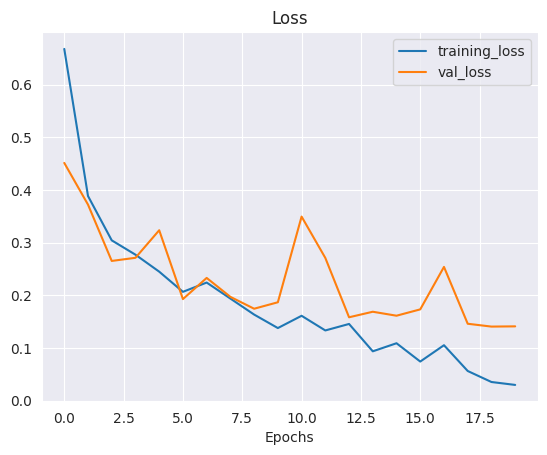

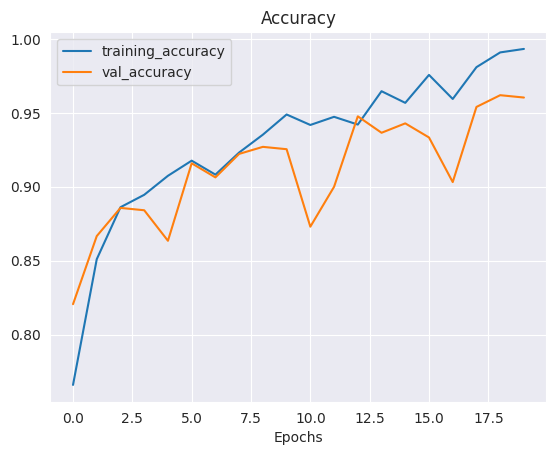

In [210]:
plot_loss_curves(resnet101_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 2s 158ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       106
           1       0.99      0.99      0.99       111
           2       0.87      0.81      0.84       103
           3       0.84      0.93      0.88       108

    accuracy                           0.91       428
   macro avg       0.91      0.91      0.91       428
weighted avg       0.91      0.91      0.91       428

Specificity: [0.2930513595166163, 0.34591194968553457, 0.24057971014492754, 0.3048780487804878]
Mean Squared Error: : 0.10666509717702866
The average AUC-ROC is 0.9838000643308232


[0.9723076923076923,
 0.6656151419558359,
 0.6936936936936937,
 0.6731391585760518,
 0.6584615384615384,
 0.9968454258675079,
 0.6696696696696697,
 0.6407766990291263,
 0.6984615384615385,
 0.6782334384858044,
 0.93993993993994,
 0.7119741100323624,
 0.6707692307692308,
 0.6593059936908517,
 0.6966966966966966,
 0.9741100323624595]

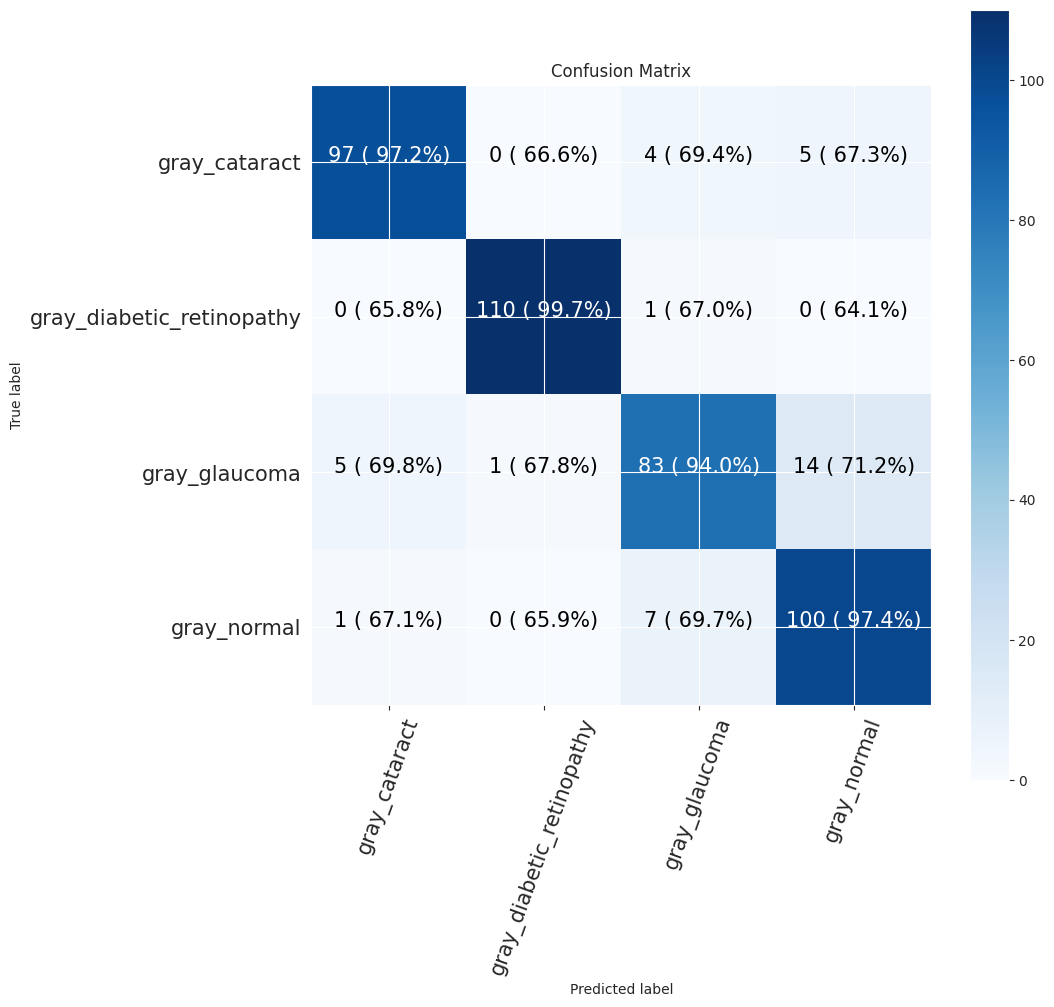

In [211]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


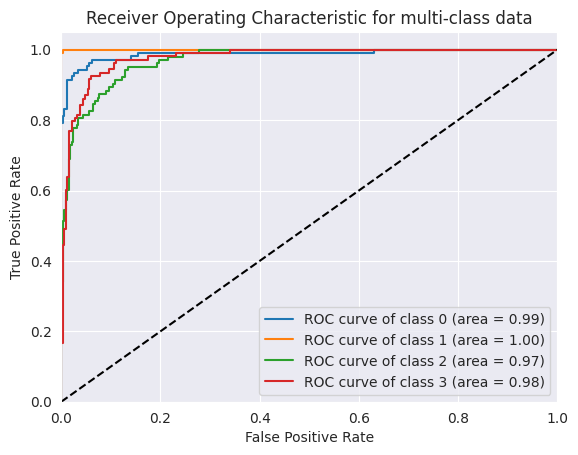

In [212]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **Batch size: 64**

In [213]:
epoch = 20
batchsize = 64

In [214]:
train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_classes = sorted([name for name in os.listdir(train_dir)])
class_names = train_classes  # Assuming class names are the same across train, test, and val

# Load datasets
train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 3813 files belonging to 4 classes.
Found 428 files belonging to 4 classes.
Found 630 files belonging to 4 classes.


In [215]:
train_data = train_data.map(lambda x, y: (sharpen_image(x), y))
test_data = test_data.map(lambda x, y: (sharpen_image(x), y))
val_data = val_data.map(lambda x, y: (sharpen_image(x), y))

# **EfficientNetV2B3 Model**

In [216]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


In [217]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = data_aug(inputs)
# x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 1)     0         
 equential)                                                      
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d_1  (None, 1536)              0         
 9 (GlobalAveragePooling2D)                                      
                                                                 
 dense_56 (Dense)            (None, 32)                49184     
                                                          

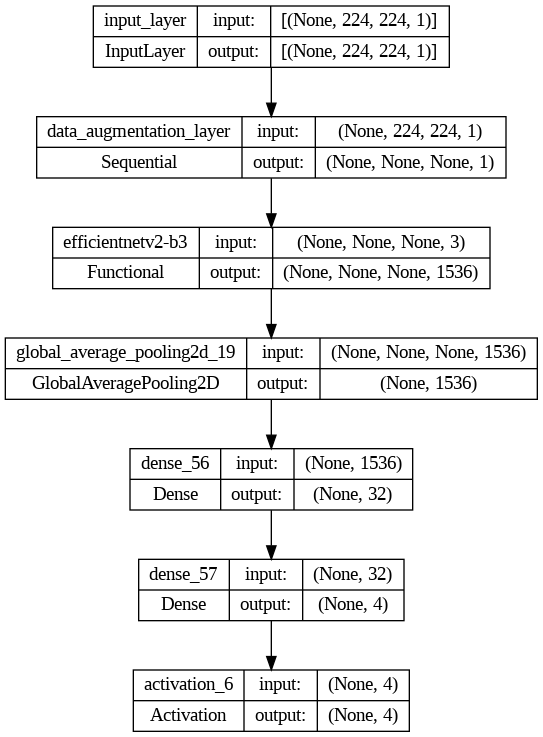

In [218]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [219]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [220]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
60/60 [==============================] - 76s 1s/step - loss: 0.8269 - accuracy: 0.6630 - val_loss: 0.8340 - val_accuracy: 0.6524 - lr: 0.0010
Epoch 2/20
60/60 [==============================] - 48s 794ms/step - loss: 0.5949 - accuracy: 0.7579 - val_loss: 0.8261 - val_accuracy: 0.6302 - lr: 0.0010
Epoch 3/20
60/60 [==============================] - 49s 815ms/step - loss: 0.5611 - accuracy: 0.7771 - val_loss: 0.7461 - val_accuracy: 0.6968 - lr: 0.0010
Epoch 4/20
60/60 [==============================] - 50s 814ms/step - loss: 0.5012 - accuracy: 0.8135 - val_loss: 0.6973 - val_accuracy: 0.7238 - lr: 0.0010
Epoch 5/20
60/60 [==============================] - 48s 814ms/step - loss: 0.5079 - accuracy: 0.8036 - val_loss: 0.7333 - val_accuracy: 0.6857 - lr: 0.0010
Epoch 6/20
60/60 [==============================] - 44s 729ms/step - loss: 0.4868 - accuracy: 0.8065 - val_loss: 0.6292 - val_accuracy: 0.7651 - lr: 0.0010
Epoch 7/20
60/60 [==============================] - 44s 734ms/step 

EfficientNetV2B3 Evaluation

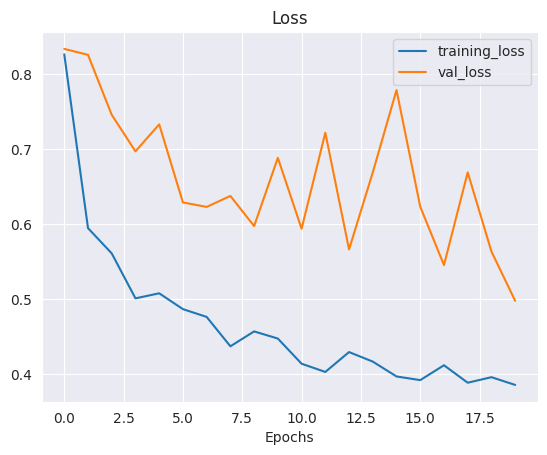

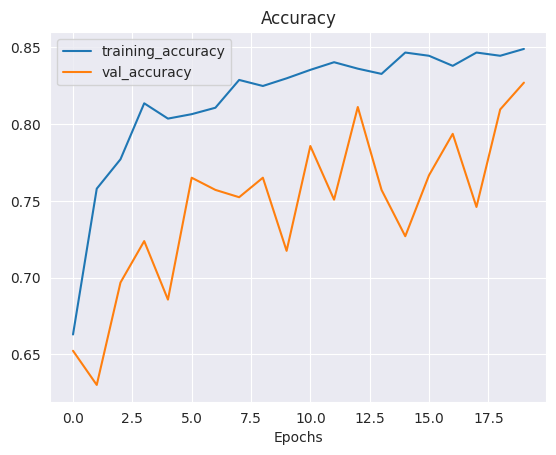

In [221]:
plot_loss_curves(efficient_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 1s 148ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       106
           1       0.93      0.89      0.91       111
           2       0.92      0.66      0.77       103
           3       0.69      0.94      0.80       108

    accuracy                           0.84       428
   macro avg       0.86      0.84      0.84       428
weighted avg       0.86      0.84      0.84       428

Specificity: [0.27380952380952384, 0.3009118541033435, 0.18888888888888888, 0.308868501529052]
Mean Squared Error: : 0.12449325621128082
The average AUC-ROC is 0.9637571162137197


[0.9571865443425076,
 0.6697819314641744,
 0.7175141242937854,
 0.6524822695035462,
 0.6605504587155964,
 0.9626168224299065,
 0.6864406779661016,
 0.648936170212766,
 0.709480122324159,
 0.6853582554517134,
 0.9011299435028248,
 0.723404255319149,
 0.672782874617737,
 0.6822429906542056,
 0.6949152542372882,
 0.975177304964539]

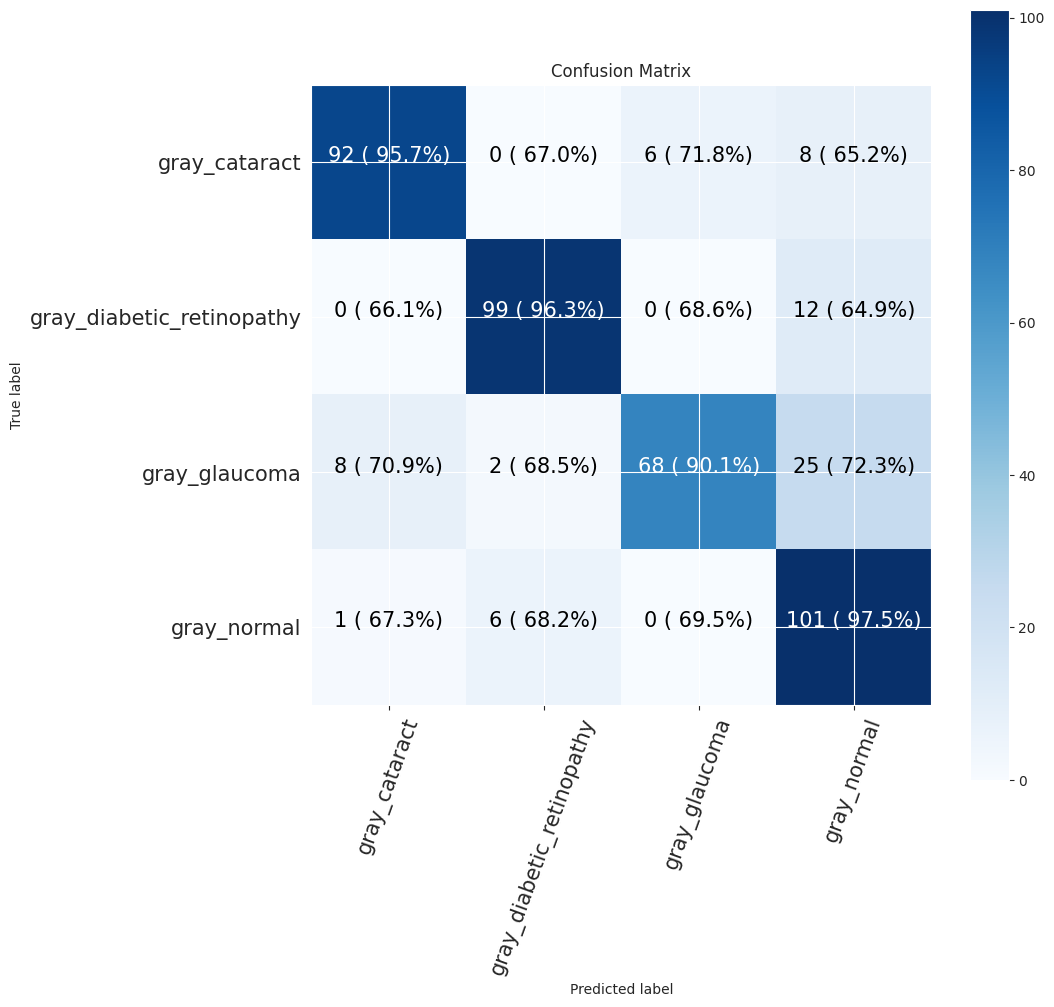

In [222]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


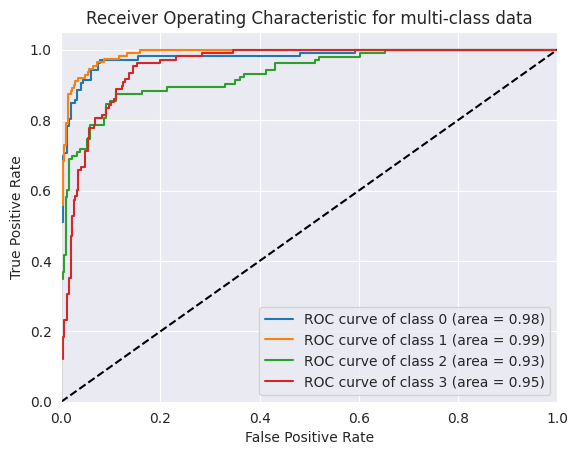

In [223]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [224]:
from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_38 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_39 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 26, 26, 128)      

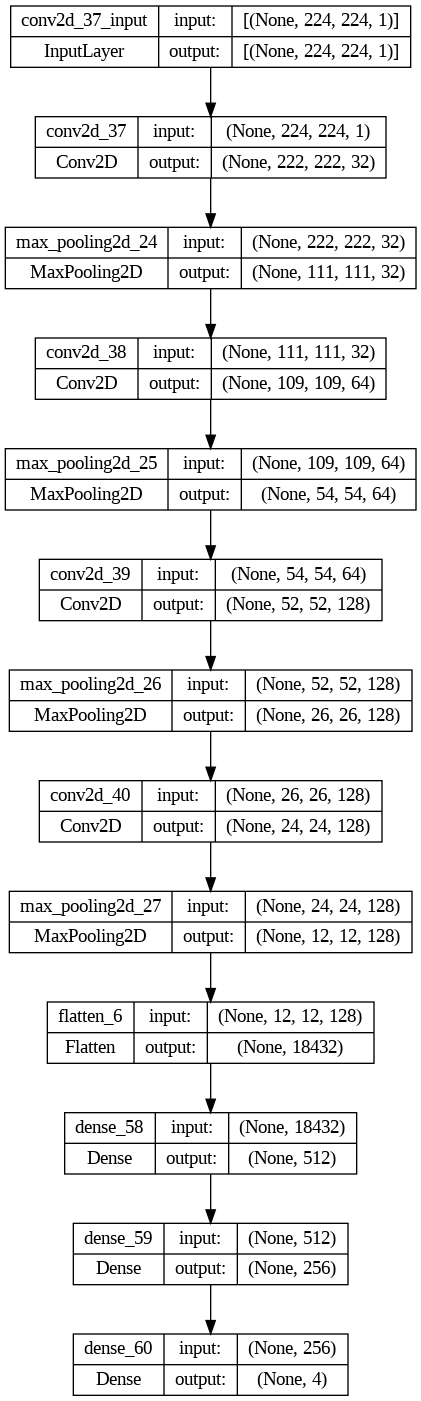

In [225]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [226]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [227]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
60/60 [==============================] - 7s 85ms/step - loss: 7.2238 - accuracy: 0.5022 - val_loss: 0.7577 - val_accuracy: 0.6937 - lr: 0.0010
Epoch 2/20
60/60 [==============================] - 4s 66ms/step - loss: 0.6398 - accuracy: 0.7283 - val_loss: 0.5680 - val_accuracy: 0.7603 - lr: 0.0010
Epoch 3/20
60/60 [==============================] - 4s 66ms/step - loss: 0.5944 - accuracy: 0.7564 - val_loss: 0.5783 - val_accuracy: 0.7667 - lr: 0.0010
Epoch 4/20
60/60 [==============================] - 4s 66ms/step - loss: 0.5154 - accuracy: 0.7831 - val_loss: 0.6026 - val_accuracy: 0.7603 - lr: 0.0010
Epoch 5/20
60/60 [==============================] - 4s 66ms/step - loss: 0.4520 - accuracy: 0.8122 - val_loss: 0.4684 - val_accuracy: 0.8302 - lr: 0.0010
Epoch 6/20
60/60 [==============================] - 4s 66ms/step - loss: 0.4082 - accuracy: 0.8308 - val_loss: 0.4447 - val_accuracy: 0.8302 - lr: 0.0010
Epoch 7/20
60/60 [==============================] - 4s 66ms/step - loss: 0.3

CNN Evaluation

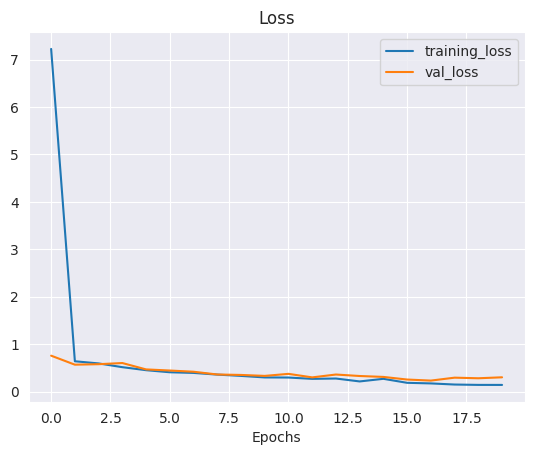

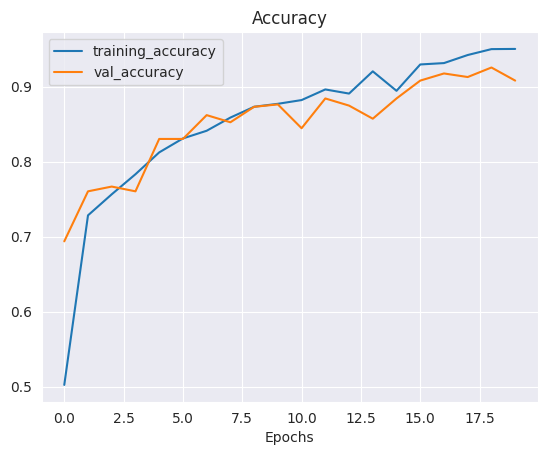

In [228]:
plot_loss_curves(cnn_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 0s 24ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.86      0.81       106
           1       0.97      1.00      0.99       111
           2       0.80      0.68      0.74       103
           3       0.83      0.83      0.83       108

    accuracy                           0.85       428
   macro avg       0.84      0.84      0.84       428
weighted avg       0.85      0.85      0.84       428

Specificity: [0.27002967359050445, 0.3501577287066246, 0.19553072625698323, 0.26627218934911245]
Mean Squared Error: : 0.11724193394184113
The average AUC-ROC is 0.9559059504317448


[0.9514563106796117,
 0.6687898089171974,
 0.7096774193548387,
 0.6875,
 0.6407766990291263,
 1.0,
 0.6744868035190615,
 0.653125,
 0.7346278317152104,
 0.6719745222929936,
 0.9032258064516129,
 0.715625,
 0.6731391585760518,
 0.6592356687898089,
 0.7126099706744868,
 0.94375]

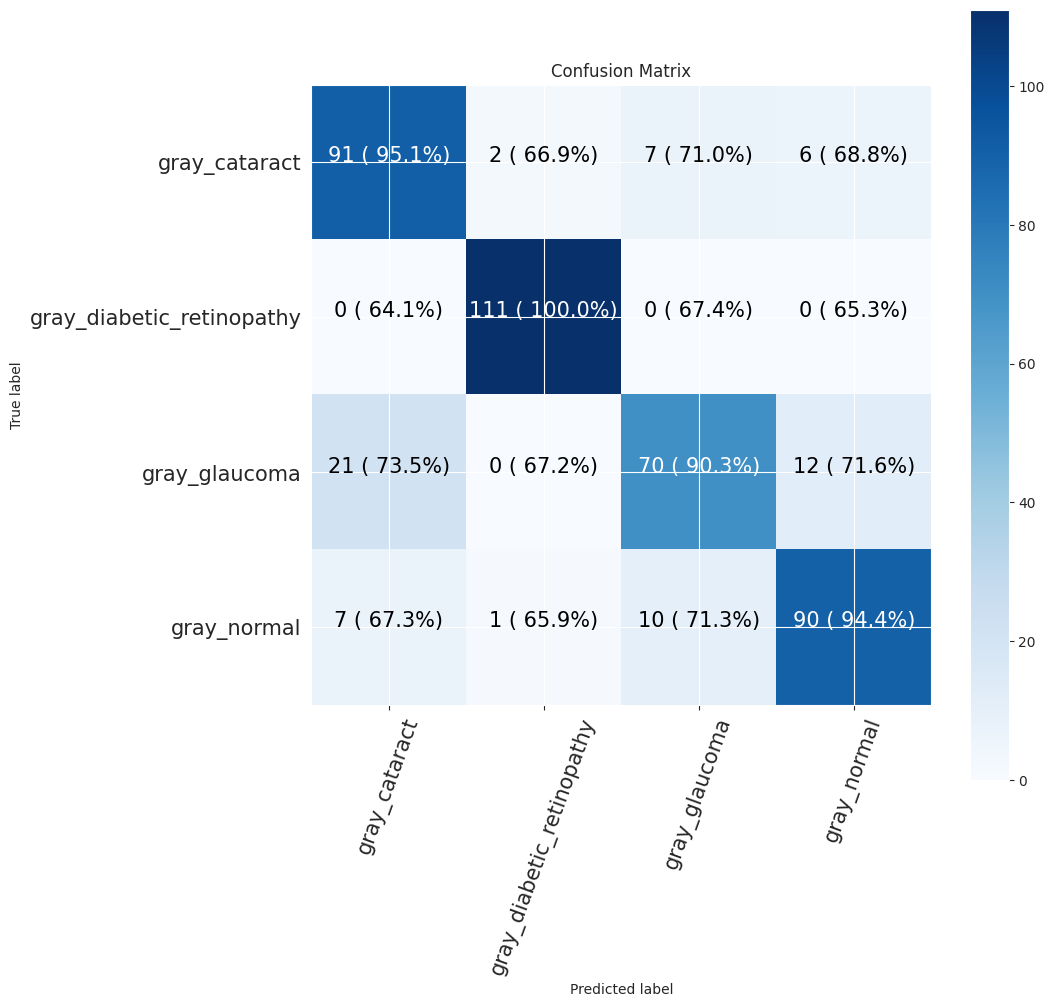

In [229]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


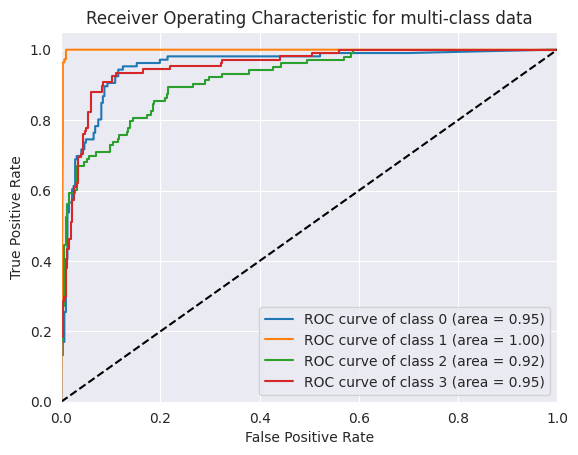

In [230]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [231]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_56 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_41 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
 0 (GlobalAveragePooling2D)                                      
                                                                 
 dense_61 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_62 (Dense)            (None, 4)                 4100      
                                                          

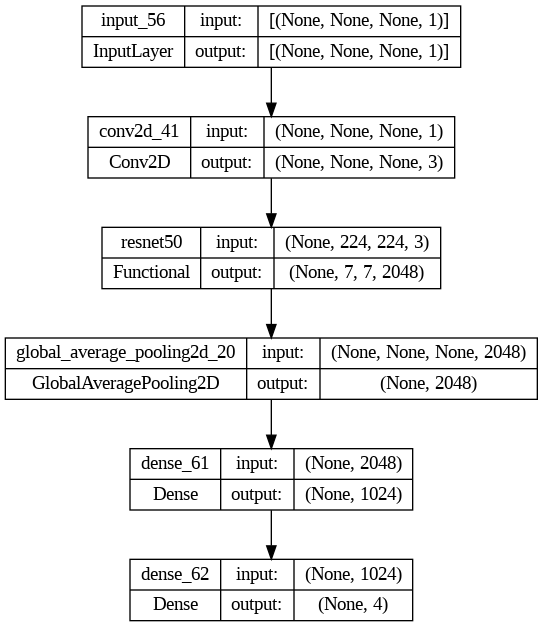

In [232]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [233]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [234]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
60/60 [==============================] - 39s 583ms/step - loss: 0.7713 - accuracy: 0.7333 - val_loss: 0.4618 - val_accuracy: 0.8048 - lr: 0.0010
Epoch 2/20
60/60 [==============================] - 31s 508ms/step - loss: 0.3789 - accuracy: 0.8613 - val_loss: 0.3205 - val_accuracy: 0.8825 - lr: 0.0010
Epoch 3/20
60/60 [==============================] - 30s 504ms/step - loss: 0.3060 - accuracy: 0.8862 - val_loss: 0.2698 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 4/20
60/60 [==============================] - 31s 509ms/step - loss: 0.2576 - accuracy: 0.9045 - val_loss: 0.2828 - val_accuracy: 0.8921 - lr: 0.0010
Epoch 5/20
60/60 [==============================] - 31s 507ms/step - loss: 0.2375 - accuracy: 0.9116 - val_loss: 0.3660 - val_accuracy: 0.8556 - lr: 0.0010
Epoch 6/20
60/60 [==============================] - 31s 506ms/step - loss: 0.2107 - accuracy: 0.9195 - val_loss: 0.2217 - val_accuracy: 0.9063 - lr: 0.0010
Epoch 7/20
60/60 [==============================] - 31s 507ms/st

ResNet50 Evaluation

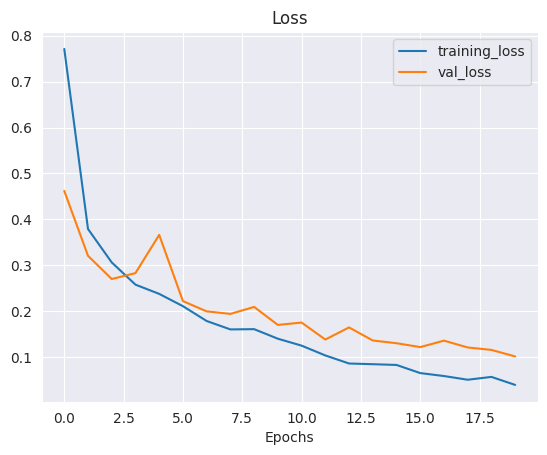

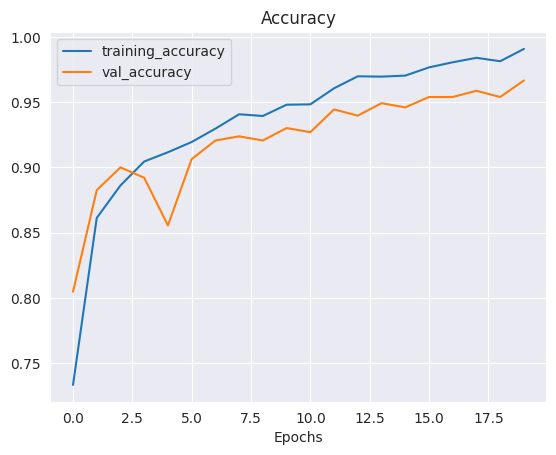

In [235]:
plot_loss_curves(resnet50_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 1s 179ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       106
           1       0.99      0.99      0.99       111
           2       0.83      0.87      0.85       103
           3       0.90      0.87      0.89       108

    accuracy                           0.91       428
   macro avg       0.91      0.91      0.91       428
weighted avg       0.91      0.91      0.91       428

Specificity: [0.2930513595166163, 0.34591194968553457, 0.26627218934911245, 0.281437125748503]
Mean Squared Error: : 0.10560262203216553
The average AUC-ROC is 0.9889732936311502


[0.9721362229102167,
 0.6656151419558359,
 0.690625,
 0.6790123456790124,
 0.6563467492260062,
 0.9968454258675079,
 0.65625,
 0.6574074074074074,
 0.6934984520123839,
 0.6782334384858044,
 0.959375,
 0.7067901234567902,
 0.6780185758513931,
 0.6593059936908517,
 0.69375,
 0.9567901234567902]

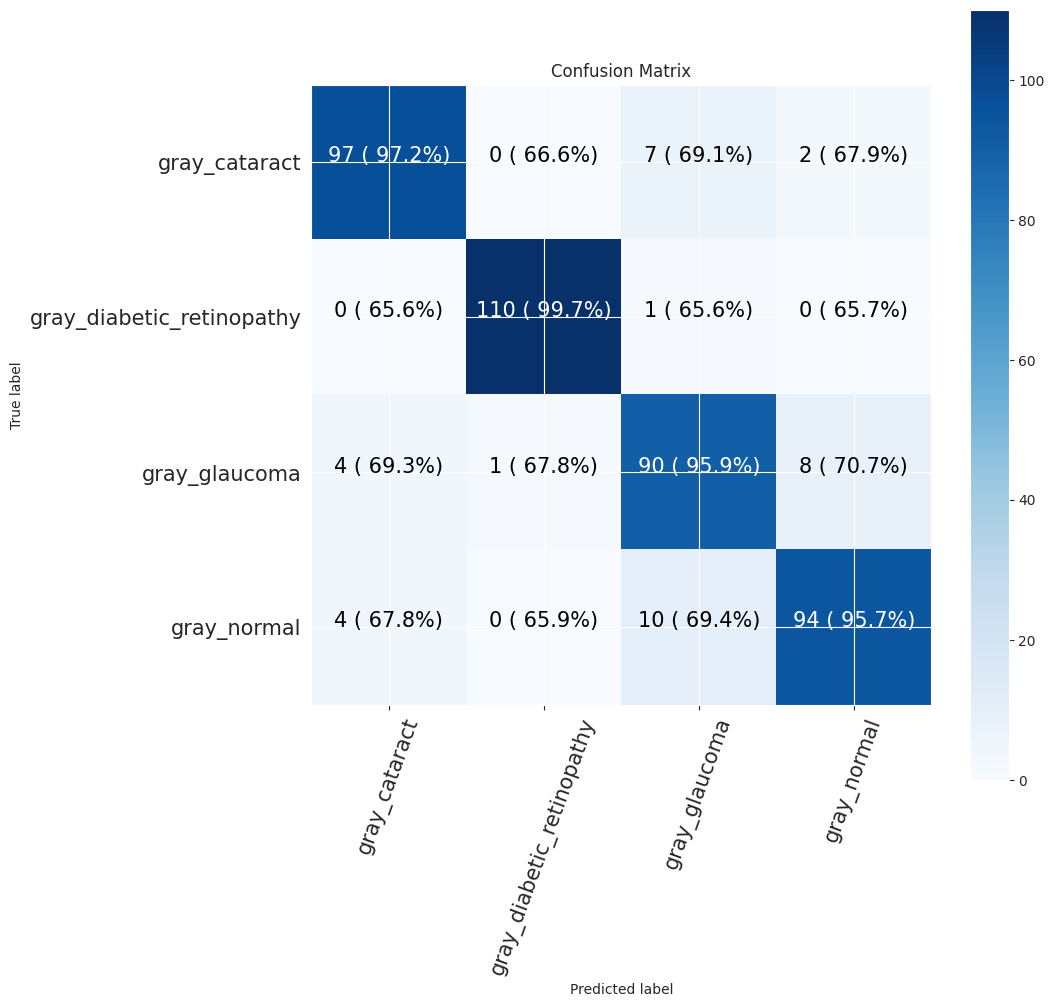

In [236]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


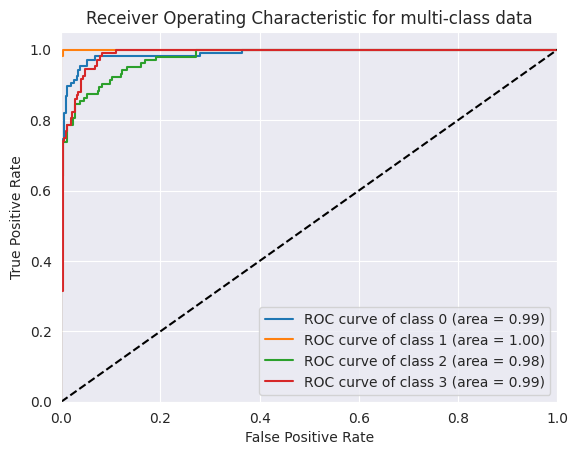

In [237]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [238]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_59 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_42 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
 1 (GlobalAveragePooling2D)                                      
                                                                 
 dense_63 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_64 (Dense)            (None, 4)                 4100      
                                                          

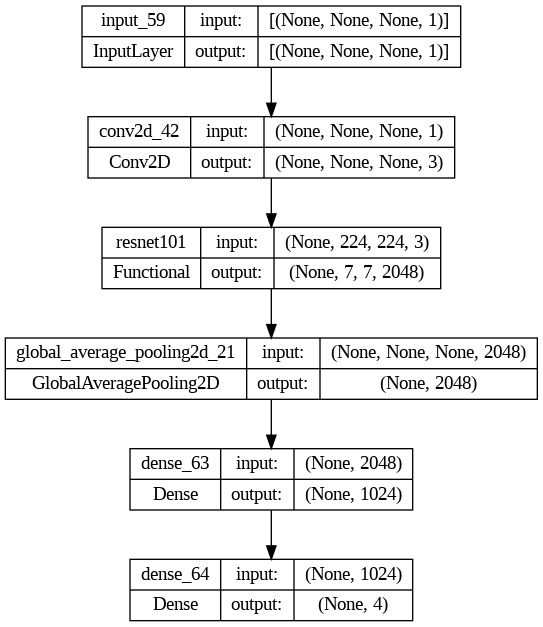

In [239]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [240]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [241]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
60/60 [==============================] - 60s 873ms/step - loss: 1.0194 - accuracy: 0.6916 - val_loss: 0.4730 - val_accuracy: 0.8127 - lr: 0.0010
Epoch 2/20
60/60 [==============================] - 50s 823ms/step - loss: 0.4298 - accuracy: 0.8377 - val_loss: 0.3710 - val_accuracy: 0.8619 - lr: 0.0010
Epoch 3/20
60/60 [==============================] - 50s 828ms/step - loss: 0.3833 - accuracy: 0.8419 - val_loss: 0.3501 - val_accuracy: 0.8698 - lr: 0.0010
Epoch 4/20
60/60 [==============================] - 50s 825ms/step - loss: 0.3698 - accuracy: 0.8558 - val_loss: 0.3090 - val_accuracy: 0.8841 - lr: 0.0010
Epoch 5/20
60/60 [==============================] - 50s 828ms/step - loss: 0.3032 - accuracy: 0.8820 - val_loss: 0.2889 - val_accuracy: 0.8905 - lr: 0.0010
Epoch 6/20
60/60 [==============================] - 50s 829ms/step - loss: 0.2952 - accuracy: 0.8794 - val_loss: 0.2974 - val_accuracy: 0.8825 - lr: 0.0010
Epoch 7/20
60/60 [==============================] - 50s 828ms/st

ResNet101 Evaluation

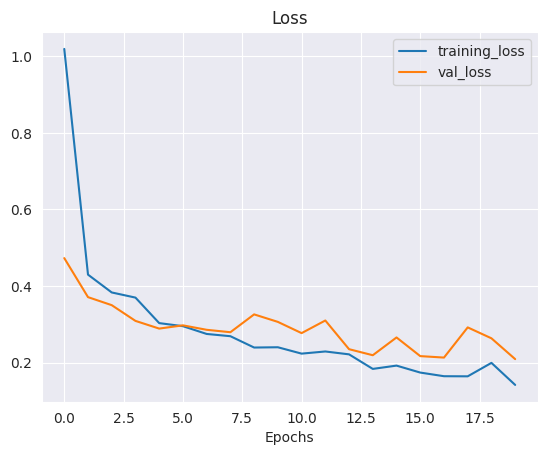

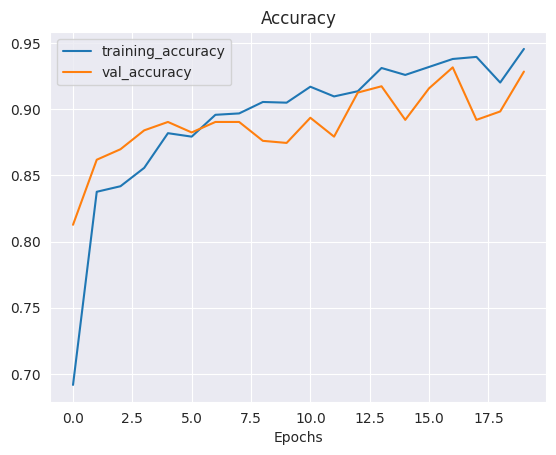

In [242]:
plot_loss_curves(resnet101_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 2s 295ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       106
           1       0.96      1.00      0.98       111
           2       0.75      0.76      0.75       103
           3       0.86      0.77      0.81       108

    accuracy                           0.86       428
   macro avg       0.85      0.85      0.85       428
weighted avg       0.85      0.86      0.85       428

Specificity: [0.281437125748503, 0.3501577287066246, 0.22285714285714286, 0.24057971014492754]
Mean Squared Error: : 0.11371222138404846
The average AUC-ROC is 0.9728847931140967


[0.9620253164556962,
 0.6634615384615384,
 0.6975308641975309,
 0.6897590361445783,
 0.6487341772151899,
 1.0,
 0.6574074074074074,
 0.6656626506024096,
 0.7151898734177216,
 0.6762820512820513,
 0.9228395061728395,
 0.7198795180722891,
 0.6740506329113924,
 0.6602564102564102,
 0.7222222222222222,
 0.9246987951807228]

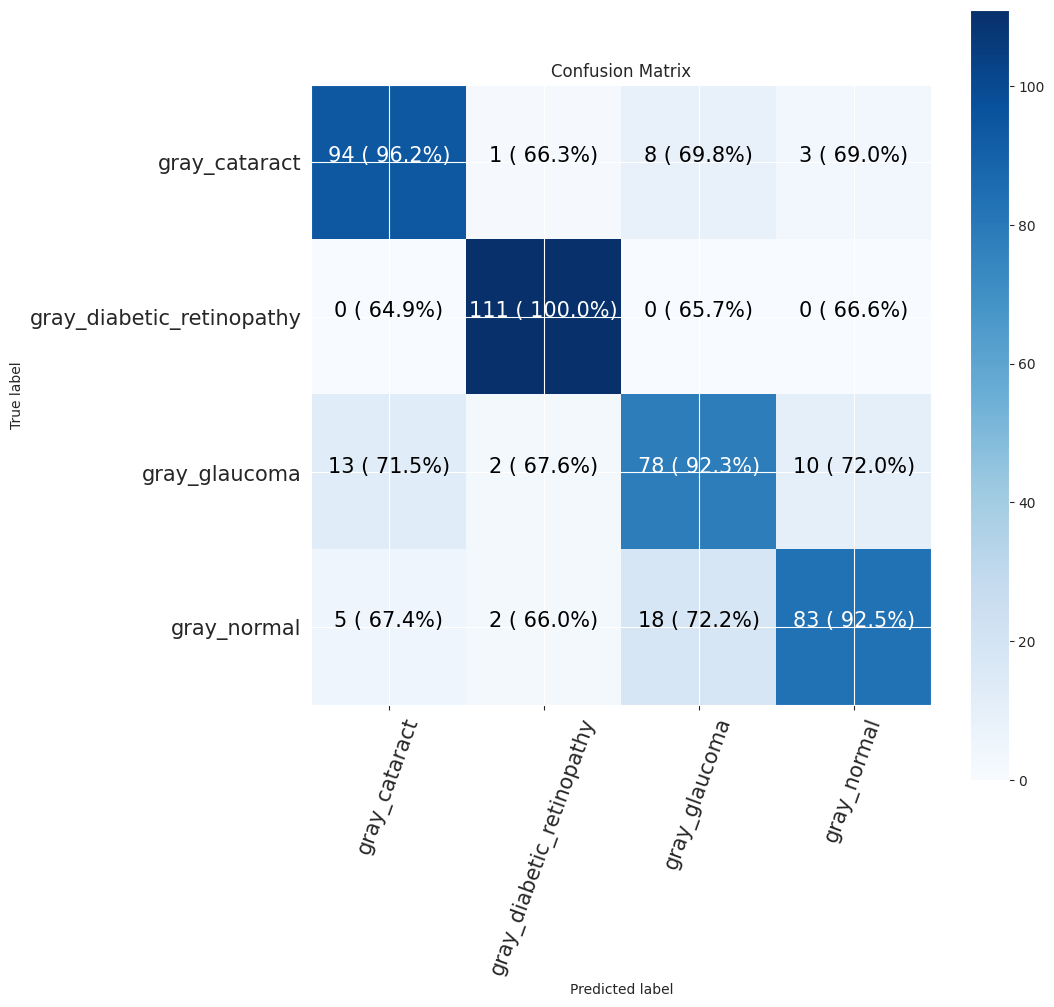

In [243]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


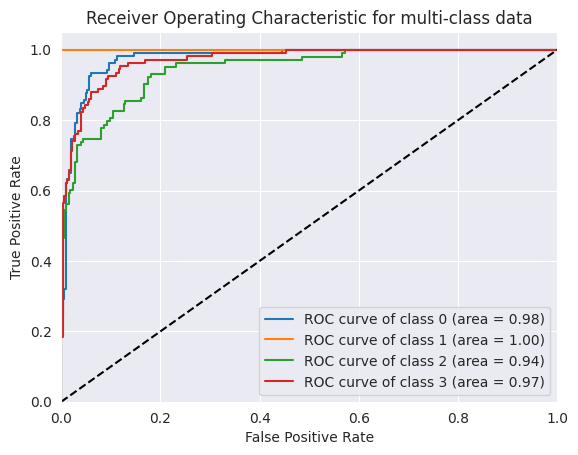

In [244]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()